# ConvAge2  
Lighter SegNet architecture, shrinking appens only in the first two VGG-Face layers.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from data_utils import FaceData
import time
import os

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.ion()   # interactive mode

In [2]:
train_data = FaceData(image_paths_file='LAG/train/train.txt')
val_data = FaceData(image_paths_file='LAG/val/val.txt')
print(train_data[0][1].size)
print(train_data[0][0].size())

<built-in method size of torch.FloatTensor object at 0x7fc8f64d3988>
torch.Size([3, 200, 200])


Train size: 1489
Validation size: 260
Img size:  torch.Size([3, 200, 200])
Segmentation size:  torch.Size([200, 200])


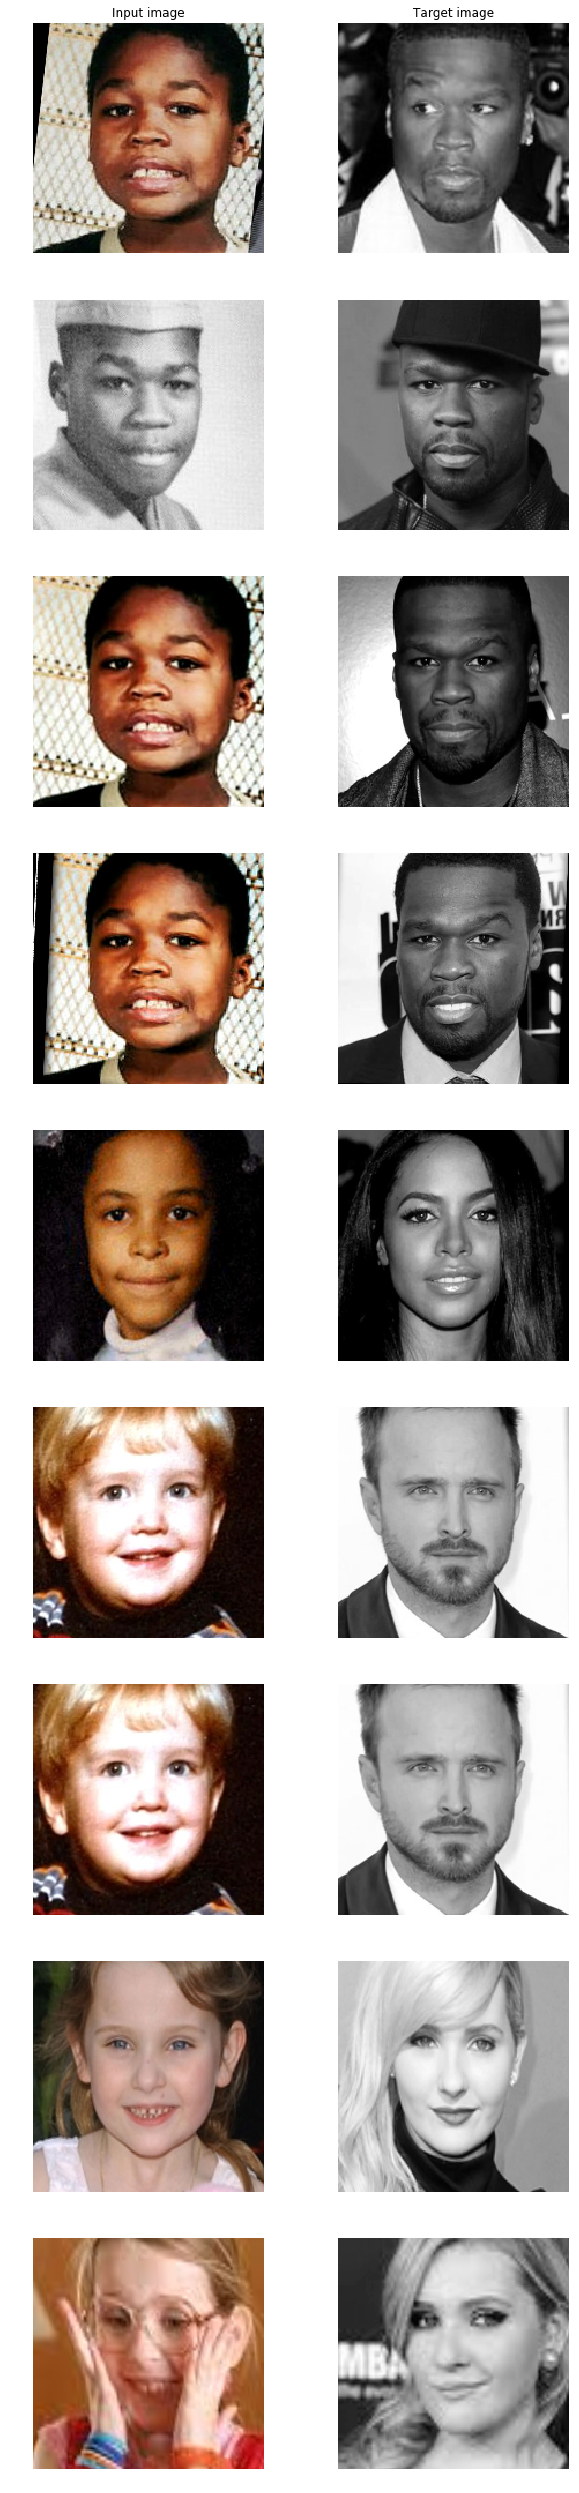

In [8]:
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Img size: ", train_data[0][0].size())
print("Segmentation size: ", train_data[0][1].size())

num_example_imgs = 9
plt.figure(figsize=(10, 5 * num_example_imgs))
for i, (img, target) in enumerate(train_data[:num_example_imgs]):
    # img
    plt.subplot(num_example_imgs, 2, i * 2 + 1)
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.axis('off')
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 2, i * 2 + 2)
    targetsc = target.numpy() / 255
    plt.imshow(targetsc.reshape(200, 200), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title("Target image")
plt.show()

40
START TRAIN.
[Iteration 1/14890] TRAIN loss: 4.942
[Iteration 2/14890] TRAIN loss: 4.601
[Iteration 3/14890] TRAIN loss: 4.862
[Iteration 4/14890] TRAIN loss: 4.906
[Iteration 5/14890] TRAIN loss: 4.181
[Iteration 6/14890] TRAIN loss: 4.911
[Iteration 7/14890] TRAIN loss: 3.778
[Iteration 8/14890] TRAIN loss: 4.013
[Iteration 9/14890] TRAIN loss: 4.301
[Iteration 10/14890] TRAIN loss: 4.362
[Iteration 11/14890] TRAIN loss: 4.366
[Iteration 12/14890] TRAIN loss: 4.678
[Iteration 13/14890] TRAIN loss: 5.376
[Iteration 14/14890] TRAIN loss: 4.603
[Iteration 15/14890] TRAIN loss: 3.562
[Iteration 16/14890] TRAIN loss: 5.070
[Iteration 17/14890] TRAIN loss: 4.831
[Iteration 18/14890] TRAIN loss: 4.876
[Iteration 19/14890] TRAIN loss: 4.650
[Iteration 20/14890] TRAIN loss: 4.884
[Iteration 21/14890] TRAIN loss: 5.074
[Iteration 22/14890] TRAIN loss: 4.695
[Iteration 23/14890] TRAIN loss: 4.173
[Iteration 24/14890] TRAIN loss: 4.558
[Iteration 25/14890] TRAIN loss: 4.967
[Iteration 26/1489

[Iteration 209/14890] TRAIN loss: 4.738
[Iteration 210/14890] TRAIN loss: 4.878
[Iteration 211/14890] TRAIN loss: 4.242
[Iteration 212/14890] TRAIN loss: 4.902
[Iteration 213/14890] TRAIN loss: 4.663
[Iteration 214/14890] TRAIN loss: 4.657
[Iteration 215/14890] TRAIN loss: 3.618
[Iteration 216/14890] TRAIN loss: 4.620
[Iteration 217/14890] TRAIN loss: 4.786
[Iteration 218/14890] TRAIN loss: 4.963
[Iteration 219/14890] TRAIN loss: 3.842
[Iteration 220/14890] TRAIN loss: 3.500
[Iteration 221/14890] TRAIN loss: 4.739
[Iteration 222/14890] TRAIN loss: 4.258
[Iteration 223/14890] TRAIN loss: 5.079
[Iteration 224/14890] TRAIN loss: 4.797
[Iteration 225/14890] TRAIN loss: 5.097
[Iteration 226/14890] TRAIN loss: 4.591
[Iteration 227/14890] TRAIN loss: 4.210
[Iteration 228/14890] TRAIN loss: 4.580
[Iteration 229/14890] TRAIN loss: 4.913
[Iteration 230/14890] TRAIN loss: 4.455
[Iteration 231/14890] TRAIN loss: 4.681
[Iteration 232/14890] TRAIN loss: 4.140
[Iteration 233/14890] TRAIN loss: 4.747


[Iteration 414/14890] TRAIN loss: 4.136
[Iteration 415/14890] TRAIN loss: 4.542
[Iteration 416/14890] TRAIN loss: 3.860
[Iteration 417/14890] TRAIN loss: 5.004
[Iteration 418/14890] TRAIN loss: 4.792
[Iteration 419/14890] TRAIN loss: 4.834
[Iteration 420/14890] TRAIN loss: 4.800
[Iteration 421/14890] TRAIN loss: 5.019
[Iteration 422/14890] TRAIN loss: 4.805
[Iteration 423/14890] TRAIN loss: 3.685
[Iteration 424/14890] TRAIN loss: 4.202
[Iteration 425/14890] TRAIN loss: 5.043
[Iteration 426/14890] TRAIN loss: 3.606
[Iteration 427/14890] TRAIN loss: 5.115
[Iteration 428/14890] TRAIN loss: 5.182
[Iteration 429/14890] TRAIN loss: 4.878
[Iteration 430/14890] TRAIN loss: 4.071
[Iteration 431/14890] TRAIN loss: 3.384
[Iteration 432/14890] TRAIN loss: 4.845
[Iteration 433/14890] TRAIN loss: 4.804
[Iteration 434/14890] TRAIN loss: 4.580
[Iteration 435/14890] TRAIN loss: 4.401
[Iteration 436/14890] TRAIN loss: 4.402
[Iteration 437/14890] TRAIN loss: 4.608
[Iteration 438/14890] TRAIN loss: 3.964


[Iteration 619/14890] TRAIN loss: 4.999
[Iteration 620/14890] TRAIN loss: 4.733
[Iteration 621/14890] TRAIN loss: 4.775
[Iteration 622/14890] TRAIN loss: 4.629
[Iteration 623/14890] TRAIN loss: 4.099
[Iteration 624/14890] TRAIN loss: 4.590
[Iteration 625/14890] TRAIN loss: 4.627
[Iteration 626/14890] TRAIN loss: 4.967
[Iteration 627/14890] TRAIN loss: 5.366
[Iteration 628/14890] TRAIN loss: 4.560
[Iteration 629/14890] TRAIN loss: 3.533
[Iteration 630/14890] TRAIN loss: 4.810
[Iteration 631/14890] TRAIN loss: 5.113
[Iteration 632/14890] TRAIN loss: 4.578
[Iteration 633/14890] TRAIN loss: 3.900
[Iteration 634/14890] TRAIN loss: 4.844
[Iteration 635/14890] TRAIN loss: 4.568
[Iteration 636/14890] TRAIN loss: 4.102
[Iteration 637/14890] TRAIN loss: 4.730
[Iteration 638/14890] TRAIN loss: 4.696
[Iteration 639/14890] TRAIN loss: 4.660
[Iteration 640/14890] TRAIN loss: 4.834
[Iteration 641/14890] TRAIN loss: 4.971
[Iteration 642/14890] TRAIN loss: 4.271
[Iteration 643/14890] TRAIN loss: 4.828


[Iteration 824/14890] TRAIN loss: 4.801
[Iteration 825/14890] TRAIN loss: 4.372
[Iteration 826/14890] TRAIN loss: 4.624
[Iteration 827/14890] TRAIN loss: 4.704
[Iteration 828/14890] TRAIN loss: 4.659
[Iteration 829/14890] TRAIN loss: 4.189
[Iteration 830/14890] TRAIN loss: 3.683
[Iteration 831/14890] TRAIN loss: 4.938
[Iteration 832/14890] TRAIN loss: 4.478
[Iteration 833/14890] TRAIN loss: 3.816
[Iteration 834/14890] TRAIN loss: 4.911
[Iteration 835/14890] TRAIN loss: 4.927
[Iteration 836/14890] TRAIN loss: 4.865
[Iteration 837/14890] TRAIN loss: 4.760
[Iteration 838/14890] TRAIN loss: 2.786
[Iteration 839/14890] TRAIN loss: 5.206
[Iteration 840/14890] TRAIN loss: 5.054
[Iteration 841/14890] TRAIN loss: 4.796
[Iteration 842/14890] TRAIN loss: 5.002
[Iteration 843/14890] TRAIN loss: 4.647
[Iteration 844/14890] TRAIN loss: 4.104
[Iteration 845/14890] TRAIN loss: 3.958
[Iteration 846/14890] TRAIN loss: 3.545
[Iteration 847/14890] TRAIN loss: 4.891
[Iteration 848/14890] TRAIN loss: 4.910


[Iteration 1029/14890] TRAIN loss: 3.861
[Iteration 1030/14890] TRAIN loss: 4.724
[Iteration 1031/14890] TRAIN loss: 4.665
[Iteration 1032/14890] TRAIN loss: 4.615
[Iteration 1033/14890] TRAIN loss: 4.427
[Iteration 1034/14890] TRAIN loss: 4.869
[Iteration 1035/14890] TRAIN loss: 4.843
[Iteration 1036/14890] TRAIN loss: 5.228
[Iteration 1037/14890] TRAIN loss: 4.438
[Iteration 1038/14890] TRAIN loss: 3.663
[Iteration 1039/14890] TRAIN loss: 3.886
[Iteration 1040/14890] TRAIN loss: 4.539
[Iteration 1041/14890] TRAIN loss: 4.490
[Iteration 1042/14890] TRAIN loss: 4.826
[Iteration 1043/14890] TRAIN loss: 4.098
[Iteration 1044/14890] TRAIN loss: 4.865
[Iteration 1045/14890] TRAIN loss: 4.703
[Iteration 1046/14890] TRAIN loss: 4.336
[Iteration 1047/14890] TRAIN loss: 3.975
[Iteration 1048/14890] TRAIN loss: 4.894
[Iteration 1049/14890] TRAIN loss: 4.694
[Iteration 1050/14890] TRAIN loss: 4.757
[Iteration 1051/14890] TRAIN loss: 4.842
[Iteration 1052/14890] TRAIN loss: 4.684
[Iteration 1053/

[Iteration 1229/14890] TRAIN loss: 4.025
[Iteration 1230/14890] TRAIN loss: 5.148
[Iteration 1231/14890] TRAIN loss: 4.839
[Iteration 1232/14890] TRAIN loss: 4.707
[Iteration 1233/14890] TRAIN loss: 5.021
[Iteration 1234/14890] TRAIN loss: 4.510
[Iteration 1235/14890] TRAIN loss: 4.642
[Iteration 1236/14890] TRAIN loss: 4.756
[Iteration 1237/14890] TRAIN loss: 4.575
[Iteration 1238/14890] TRAIN loss: 4.280
[Iteration 1239/14890] TRAIN loss: 4.945
[Iteration 1240/14890] TRAIN loss: 4.917
[Iteration 1241/14890] TRAIN loss: 4.655
[Iteration 1242/14890] TRAIN loss: 4.577
[Iteration 1243/14890] TRAIN loss: 3.727
[Iteration 1244/14890] TRAIN loss: 4.599
[Iteration 1245/14890] TRAIN loss: 4.655
[Iteration 1246/14890] TRAIN loss: 4.213
[Iteration 1247/14890] TRAIN loss: 3.641
[Iteration 1248/14890] TRAIN loss: 5.145
[Iteration 1249/14890] TRAIN loss: 3.465
[Iteration 1250/14890] TRAIN loss: 4.665
[Iteration 1251/14890] TRAIN loss: 3.583
[Iteration 1252/14890] TRAIN loss: 4.271
[Iteration 1253/

[Iteration 1429/14890] TRAIN loss: 4.729
[Iteration 1430/14890] TRAIN loss: 4.674
[Iteration 1431/14890] TRAIN loss: 4.847
[Iteration 1432/14890] TRAIN loss: 4.781
[Iteration 1433/14890] TRAIN loss: 4.060
[Iteration 1434/14890] TRAIN loss: 4.979
[Iteration 1435/14890] TRAIN loss: 4.451
[Iteration 1436/14890] TRAIN loss: 4.431
[Iteration 1437/14890] TRAIN loss: 4.175
[Iteration 1438/14890] TRAIN loss: 4.063
[Iteration 1439/14890] TRAIN loss: 4.751
[Iteration 1440/14890] TRAIN loss: 4.923
[Iteration 1441/14890] TRAIN loss: 4.641
[Iteration 1442/14890] TRAIN loss: 4.721
[Iteration 1443/14890] TRAIN loss: 4.767
[Iteration 1444/14890] TRAIN loss: 4.891
[Iteration 1445/14890] TRAIN loss: 4.262
[Iteration 1446/14890] TRAIN loss: 4.545
[Iteration 1447/14890] TRAIN loss: 4.544
[Iteration 1448/14890] TRAIN loss: 4.955
[Iteration 1449/14890] TRAIN loss: 3.955
[Iteration 1450/14890] TRAIN loss: 4.750
[Iteration 1451/14890] TRAIN loss: 4.595
[Iteration 1452/14890] TRAIN loss: 4.746
[Iteration 1453/

[Iteration 1627/14890] TRAIN loss: 4.474
[Iteration 1628/14890] TRAIN loss: 4.810
[Iteration 1629/14890] TRAIN loss: 3.708
[Iteration 1630/14890] TRAIN loss: 4.806
[Iteration 1631/14890] TRAIN loss: 3.596
[Iteration 1632/14890] TRAIN loss: 4.169
[Iteration 1633/14890] TRAIN loss: 5.050
[Iteration 1634/14890] TRAIN loss: 3.828
[Iteration 1635/14890] TRAIN loss: 4.083
[Iteration 1636/14890] TRAIN loss: 4.666
[Iteration 1637/14890] TRAIN loss: 4.510
[Iteration 1638/14890] TRAIN loss: 4.364
[Iteration 1639/14890] TRAIN loss: 4.140
[Iteration 1640/14890] TRAIN loss: 4.050
[Iteration 1641/14890] TRAIN loss: 4.680
[Iteration 1642/14890] TRAIN loss: 4.805
[Iteration 1643/14890] TRAIN loss: 4.646
[Iteration 1644/14890] TRAIN loss: 4.879
[Iteration 1645/14890] TRAIN loss: 4.806
[Iteration 1646/14890] TRAIN loss: 4.469
[Iteration 1647/14890] TRAIN loss: 5.032
[Iteration 1648/14890] TRAIN loss: 4.946
[Iteration 1649/14890] TRAIN loss: 4.273
[Iteration 1650/14890] TRAIN loss: 3.236
[Iteration 1651/

[Iteration 1827/14890] TRAIN loss: 4.286
[Iteration 1828/14890] TRAIN loss: 4.614
[Iteration 1829/14890] TRAIN loss: 4.466
[Iteration 1830/14890] TRAIN loss: 5.393
[Iteration 1831/14890] TRAIN loss: 4.695
[Iteration 1832/14890] TRAIN loss: 4.262
[Iteration 1833/14890] TRAIN loss: 4.524
[Iteration 1834/14890] TRAIN loss: 4.034
[Iteration 1835/14890] TRAIN loss: 3.873
[Iteration 1836/14890] TRAIN loss: 3.627
[Iteration 1837/14890] TRAIN loss: 4.976
[Iteration 1838/14890] TRAIN loss: 3.204
[Iteration 1839/14890] TRAIN loss: 4.152
[Iteration 1840/14890] TRAIN loss: 3.244
[Iteration 1841/14890] TRAIN loss: 4.776
[Iteration 1842/14890] TRAIN loss: 4.914
[Iteration 1843/14890] TRAIN loss: 3.464
[Iteration 1844/14890] TRAIN loss: 4.655
[Iteration 1845/14890] TRAIN loss: 4.306
[Iteration 1846/14890] TRAIN loss: 4.582
[Iteration 1847/14890] TRAIN loss: 5.152
[Iteration 1848/14890] TRAIN loss: 4.611
[Iteration 1849/14890] TRAIN loss: 4.266
[Iteration 1850/14890] TRAIN loss: 4.712
[Iteration 1851/

[Iteration 2027/14890] TRAIN loss: 3.963
[Iteration 2028/14890] TRAIN loss: 4.509
[Iteration 2029/14890] TRAIN loss: 4.822
[Iteration 2030/14890] TRAIN loss: 4.666
[Iteration 2031/14890] TRAIN loss: 4.807
[Iteration 2032/14890] TRAIN loss: 4.533
[Iteration 2033/14890] TRAIN loss: 4.740
[Iteration 2034/14890] TRAIN loss: 4.094
[Iteration 2035/14890] TRAIN loss: 4.076
[Iteration 2036/14890] TRAIN loss: 5.215
[Iteration 2037/14890] TRAIN loss: 4.975
[Iteration 2038/14890] TRAIN loss: 4.121
[Iteration 2039/14890] TRAIN loss: 4.953
[Iteration 2040/14890] TRAIN loss: 4.192
[Iteration 2041/14890] TRAIN loss: 4.602
[Iteration 2042/14890] TRAIN loss: 4.762
[Iteration 2043/14890] TRAIN loss: 4.008
[Iteration 2044/14890] TRAIN loss: 4.104
[Iteration 2045/14890] TRAIN loss: 4.510
[Iteration 2046/14890] TRAIN loss: 4.841
[Iteration 2047/14890] TRAIN loss: 4.486
[Iteration 2048/14890] TRAIN loss: 4.700
[Iteration 2049/14890] TRAIN loss: 4.472
[Iteration 2050/14890] TRAIN loss: 4.468
[Iteration 2051/

[Iteration 2227/14890] TRAIN loss: 4.605
[Iteration 2228/14890] TRAIN loss: 4.796
[Iteration 2229/14890] TRAIN loss: 4.947
[Iteration 2230/14890] TRAIN loss: 3.996
[Iteration 2231/14890] TRAIN loss: 4.443
[Iteration 2232/14890] TRAIN loss: 4.815
[Iteration 2233/14890] TRAIN loss: 3.365
[Iteration 2234/14890] TRAIN loss: 4.056
[Iteration 2235/14890] TRAIN loss: 3.795
[Iteration 2236/14890] TRAIN loss: 4.721
[Iteration 2237/14890] TRAIN loss: 4.540
[Iteration 2238/14890] TRAIN loss: 4.619
[Iteration 2239/14890] TRAIN loss: 4.582
[Iteration 2240/14890] TRAIN loss: 4.712
[Iteration 2241/14890] TRAIN loss: 4.689
[Iteration 2242/14890] TRAIN loss: 4.385
[Iteration 2243/14890] TRAIN loss: 4.145
[Iteration 2244/14890] TRAIN loss: 3.598
[Iteration 2245/14890] TRAIN loss: 4.673
[Iteration 2246/14890] TRAIN loss: 4.951
[Iteration 2247/14890] TRAIN loss: 4.108
[Iteration 2248/14890] TRAIN loss: 4.934
[Iteration 2249/14890] TRAIN loss: 4.756
[Iteration 2250/14890] TRAIN loss: 4.465
[Iteration 2251/

[Iteration 2427/14890] TRAIN loss: 4.525
[Iteration 2428/14890] TRAIN loss: 4.473
[Iteration 2429/14890] TRAIN loss: 4.689
[Iteration 2430/14890] TRAIN loss: 4.399
[Iteration 2431/14890] TRAIN loss: 4.287
[Iteration 2432/14890] TRAIN loss: 4.614
[Iteration 2433/14890] TRAIN loss: 3.328
[Iteration 2434/14890] TRAIN loss: 4.868
[Iteration 2435/14890] TRAIN loss: 4.741
[Iteration 2436/14890] TRAIN loss: 4.335
[Iteration 2437/14890] TRAIN loss: 4.220
[Iteration 2438/14890] TRAIN loss: 4.544
[Iteration 2439/14890] TRAIN loss: 4.699
[Iteration 2440/14890] TRAIN loss: 4.736
[Iteration 2441/14890] TRAIN loss: 3.472
[Iteration 2442/14890] TRAIN loss: 4.655
[Iteration 2443/14890] TRAIN loss: 4.715
[Iteration 2444/14890] TRAIN loss: 4.674
[Iteration 2445/14890] TRAIN loss: 4.664
[Iteration 2446/14890] TRAIN loss: 3.422
[Iteration 2447/14890] TRAIN loss: 4.701
[Iteration 2448/14890] TRAIN loss: 3.895
[Iteration 2449/14890] TRAIN loss: 4.645
[Iteration 2450/14890] TRAIN loss: 4.852
[Iteration 2451/

[Iteration 2627/14890] TRAIN loss: 4.644
[Iteration 2628/14890] TRAIN loss: 4.658
[Iteration 2629/14890] TRAIN loss: 4.915
[Iteration 2630/14890] TRAIN loss: 4.243
[Iteration 2631/14890] TRAIN loss: 4.710
[Iteration 2632/14890] TRAIN loss: 4.478
[Iteration 2633/14890] TRAIN loss: 3.969
[Iteration 2634/14890] TRAIN loss: 4.781
[Iteration 2635/14890] TRAIN loss: 4.595
[Iteration 2636/14890] TRAIN loss: 4.737
[Iteration 2637/14890] TRAIN loss: 4.092
[Iteration 2638/14890] TRAIN loss: 4.857
[Iteration 2639/14890] TRAIN loss: 4.473
[Iteration 2640/14890] TRAIN loss: 4.620
[Iteration 2641/14890] TRAIN loss: 5.030
[Iteration 2642/14890] TRAIN loss: 4.735
[Iteration 2643/14890] TRAIN loss: 4.459
[Iteration 2644/14890] TRAIN loss: 3.774
[Iteration 2645/14890] TRAIN loss: 4.659
[Iteration 2646/14890] TRAIN loss: 4.647
[Iteration 2647/14890] TRAIN loss: 4.786
[Iteration 2648/14890] TRAIN loss: 4.680
[Iteration 2649/14890] TRAIN loss: 4.845
[Iteration 2650/14890] TRAIN loss: 4.915
[Iteration 2651/

[Iteration 2827/14890] TRAIN loss: 4.974
[Iteration 2828/14890] TRAIN loss: 4.073
[Iteration 2829/14890] TRAIN loss: 4.781
[Iteration 2830/14890] TRAIN loss: 4.507
[Iteration 2831/14890] TRAIN loss: 4.966
[Iteration 2832/14890] TRAIN loss: 4.767
[Iteration 2833/14890] TRAIN loss: 4.877
[Iteration 2834/14890] TRAIN loss: 4.828
[Iteration 2835/14890] TRAIN loss: 4.549
[Iteration 2836/14890] TRAIN loss: 4.693
[Iteration 2837/14890] TRAIN loss: 4.470
[Iteration 2838/14890] TRAIN loss: 4.932
[Iteration 2839/14890] TRAIN loss: 5.104
[Iteration 2840/14890] TRAIN loss: 4.847
[Iteration 2841/14890] TRAIN loss: 4.086
[Iteration 2842/14890] TRAIN loss: 4.742
[Iteration 2843/14890] TRAIN loss: 4.247
[Iteration 2844/14890] TRAIN loss: 5.042
[Iteration 2845/14890] TRAIN loss: 5.292
[Iteration 2846/14890] TRAIN loss: 4.776
[Iteration 2847/14890] TRAIN loss: 4.898
[Iteration 2848/14890] TRAIN loss: 4.756
[Iteration 2849/14890] TRAIN loss: 4.634
[Iteration 2850/14890] TRAIN loss: 4.454
[Iteration 2851/

[Iteration 3025/14890] TRAIN loss: 4.435
[Iteration 3026/14890] TRAIN loss: 4.388
[Iteration 3027/14890] TRAIN loss: 4.257
[Iteration 3028/14890] TRAIN loss: 4.063
[Iteration 3029/14890] TRAIN loss: 4.421
[Iteration 3030/14890] TRAIN loss: 4.946
[Iteration 3031/14890] TRAIN loss: 4.998
[Iteration 3032/14890] TRAIN loss: 4.783
[Iteration 3033/14890] TRAIN loss: 3.734
[Iteration 3034/14890] TRAIN loss: 5.028
[Iteration 3035/14890] TRAIN loss: 4.864
[Iteration 3036/14890] TRAIN loss: 4.475
[Iteration 3037/14890] TRAIN loss: 4.695
[Iteration 3038/14890] TRAIN loss: 4.088
[Iteration 3039/14890] TRAIN loss: 3.583
[Iteration 3040/14890] TRAIN loss: 4.238
[Iteration 3041/14890] TRAIN loss: 3.512
[Iteration 3042/14890] TRAIN loss: 5.061
[Iteration 3043/14890] TRAIN loss: 4.124
[Iteration 3044/14890] TRAIN loss: 4.881
[Iteration 3045/14890] TRAIN loss: 5.018
[Iteration 3046/14890] TRAIN loss: 4.279
[Iteration 3047/14890] TRAIN loss: 3.623
[Iteration 3048/14890] TRAIN loss: 4.917
[Iteration 3049/

[Iteration 3225/14890] TRAIN loss: 4.717
[Iteration 3226/14890] TRAIN loss: 4.020
[Iteration 3227/14890] TRAIN loss: 4.409
[Iteration 3228/14890] TRAIN loss: 4.247
[Iteration 3229/14890] TRAIN loss: 4.450
[Iteration 3230/14890] TRAIN loss: 4.784
[Iteration 3231/14890] TRAIN loss: 4.468
[Iteration 3232/14890] TRAIN loss: 4.647
[Iteration 3233/14890] TRAIN loss: 5.069
[Iteration 3234/14890] TRAIN loss: 4.761
[Iteration 3235/14890] TRAIN loss: 3.954
[Iteration 3236/14890] TRAIN loss: 4.420
[Iteration 3237/14890] TRAIN loss: 4.723
[Iteration 3238/14890] TRAIN loss: 4.728
[Iteration 3239/14890] TRAIN loss: 4.199
[Iteration 3240/14890] TRAIN loss: 4.374
[Iteration 3241/14890] TRAIN loss: 4.059
[Iteration 3242/14890] TRAIN loss: 4.575
[Iteration 3243/14890] TRAIN loss: 4.575
[Iteration 3244/14890] TRAIN loss: 4.813
[Iteration 3245/14890] TRAIN loss: 5.006
[Iteration 3246/14890] TRAIN loss: 4.792
[Iteration 3247/14890] TRAIN loss: 4.739
[Iteration 3248/14890] TRAIN loss: 4.718
[Iteration 3249/

[Iteration 3425/14890] TRAIN loss: 4.838
[Iteration 3426/14890] TRAIN loss: 4.178
[Iteration 3427/14890] TRAIN loss: 4.798
[Iteration 3428/14890] TRAIN loss: 4.526
[Iteration 3429/14890] TRAIN loss: 4.653
[Iteration 3430/14890] TRAIN loss: 3.587
[Iteration 3431/14890] TRAIN loss: 3.709
[Iteration 3432/14890] TRAIN loss: 4.744
[Iteration 3433/14890] TRAIN loss: 4.285
[Iteration 3434/14890] TRAIN loss: 5.077
[Iteration 3435/14890] TRAIN loss: 4.537
[Iteration 3436/14890] TRAIN loss: 5.024
[Iteration 3437/14890] TRAIN loss: 4.528
[Iteration 3438/14890] TRAIN loss: 4.685
[Iteration 3439/14890] TRAIN loss: 4.577
[Iteration 3440/14890] TRAIN loss: 4.854
[Iteration 3441/14890] TRAIN loss: 4.237
[Iteration 3442/14890] TRAIN loss: 3.484
[Iteration 3443/14890] TRAIN loss: 4.992
[Iteration 3444/14890] TRAIN loss: 4.772
[Iteration 3445/14890] TRAIN loss: 4.745
[Iteration 3446/14890] TRAIN loss: 3.427
[Iteration 3447/14890] TRAIN loss: 4.701
[Iteration 3448/14890] TRAIN loss: 4.796
[Iteration 3449/

[Iteration 3625/14890] TRAIN loss: 4.660
[Iteration 3626/14890] TRAIN loss: 3.408
[Iteration 3627/14890] TRAIN loss: 4.850
[Iteration 3628/14890] TRAIN loss: 3.389
[Iteration 3629/14890] TRAIN loss: 4.854
[Iteration 3630/14890] TRAIN loss: 4.714
[Iteration 3631/14890] TRAIN loss: 4.469
[Iteration 3632/14890] TRAIN loss: 4.161
[Iteration 3633/14890] TRAIN loss: 4.766
[Iteration 3634/14890] TRAIN loss: 4.296
[Iteration 3635/14890] TRAIN loss: 3.875
[Iteration 3636/14890] TRAIN loss: 4.828
[Iteration 3637/14890] TRAIN loss: 4.362
[Iteration 3638/14890] TRAIN loss: 4.893
[Iteration 3639/14890] TRAIN loss: 3.801
[Iteration 3640/14890] TRAIN loss: 4.674
[Iteration 3641/14890] TRAIN loss: 4.812
[Iteration 3642/14890] TRAIN loss: 4.727
[Iteration 3643/14890] TRAIN loss: 4.283
[Iteration 3644/14890] TRAIN loss: 4.829
[Iteration 3645/14890] TRAIN loss: 4.681
[Iteration 3646/14890] TRAIN loss: 4.835
[Iteration 3647/14890] TRAIN loss: 4.118
[Iteration 3648/14890] TRAIN loss: 4.458
[Iteration 3649/

[Iteration 3825/14890] TRAIN loss: 4.846
[Iteration 3826/14890] TRAIN loss: 5.167
[Iteration 3827/14890] TRAIN loss: 3.875
[Iteration 3828/14890] TRAIN loss: 4.139
[Iteration 3829/14890] TRAIN loss: 4.398
[Iteration 3830/14890] TRAIN loss: 4.067
[Iteration 3831/14890] TRAIN loss: 5.135
[Iteration 3832/14890] TRAIN loss: 3.893
[Iteration 3833/14890] TRAIN loss: 4.335
[Iteration 3834/14890] TRAIN loss: 4.693
[Iteration 3835/14890] TRAIN loss: 4.411
[Iteration 3836/14890] TRAIN loss: 4.396
[Iteration 3837/14890] TRAIN loss: 4.492
[Iteration 3838/14890] TRAIN loss: 4.814
[Iteration 3839/14890] TRAIN loss: 4.702
[Iteration 3840/14890] TRAIN loss: 4.613
[Iteration 3841/14890] TRAIN loss: 4.992
[Iteration 3842/14890] TRAIN loss: 4.343
[Iteration 3843/14890] TRAIN loss: 4.545
[Iteration 3844/14890] TRAIN loss: 3.637
[Iteration 3845/14890] TRAIN loss: 4.555
[Iteration 3846/14890] TRAIN loss: 5.034
[Iteration 3847/14890] TRAIN loss: 4.453
[Iteration 3848/14890] TRAIN loss: 4.786
[Iteration 3849/

[Iteration 4025/14890] TRAIN loss: 4.557
[Iteration 4026/14890] TRAIN loss: 4.720
[Iteration 4027/14890] TRAIN loss: 4.469
[Iteration 4028/14890] TRAIN loss: 3.842
[Iteration 4029/14890] TRAIN loss: 4.554
[Iteration 4030/14890] TRAIN loss: 4.201
[Iteration 4031/14890] TRAIN loss: 4.172
[Iteration 4032/14890] TRAIN loss: 4.777
[Iteration 4033/14890] TRAIN loss: 4.842
[Iteration 4034/14890] TRAIN loss: 4.865
[Iteration 4035/14890] TRAIN loss: 4.790
[Iteration 4036/14890] TRAIN loss: 4.125
[Iteration 4037/14890] TRAIN loss: 4.353
[Iteration 4038/14890] TRAIN loss: 4.810
[Iteration 4039/14890] TRAIN loss: 4.916
[Iteration 4040/14890] TRAIN loss: 4.680
[Iteration 4041/14890] TRAIN loss: 4.834
[Iteration 4042/14890] TRAIN loss: 4.943
[Iteration 4043/14890] TRAIN loss: 4.245
[Iteration 4044/14890] TRAIN loss: 3.460
[Iteration 4045/14890] TRAIN loss: 4.741
[Iteration 4046/14890] TRAIN loss: 4.877
[Iteration 4047/14890] TRAIN loss: 5.066
[Iteration 4048/14890] TRAIN loss: 4.276
[Iteration 4049/

[Iteration 4225/14890] TRAIN loss: 4.712
[Iteration 4226/14890] TRAIN loss: 4.530
[Iteration 4227/14890] TRAIN loss: 4.517
[Iteration 4228/14890] TRAIN loss: 4.760
[Iteration 4229/14890] TRAIN loss: 4.108
[Iteration 4230/14890] TRAIN loss: 4.430
[Iteration 4231/14890] TRAIN loss: 4.712
[Iteration 4232/14890] TRAIN loss: 3.381
[Iteration 4233/14890] TRAIN loss: 4.696
[Iteration 4234/14890] TRAIN loss: 4.914
[Iteration 4235/14890] TRAIN loss: 4.869
[Iteration 4236/14890] TRAIN loss: 4.702
[Iteration 4237/14890] TRAIN loss: 4.818
[Iteration 4238/14890] TRAIN loss: 3.829
[Iteration 4239/14890] TRAIN loss: 4.695
[Iteration 4240/14890] TRAIN loss: 4.794
[Iteration 4241/14890] TRAIN loss: 4.654
[Iteration 4242/14890] TRAIN loss: 4.633
[Iteration 4243/14890] TRAIN loss: 4.940
[Iteration 4244/14890] TRAIN loss: 4.356
[Iteration 4245/14890] TRAIN loss: 4.149
[Iteration 4246/14890] TRAIN loss: 4.108
[Iteration 4247/14890] TRAIN loss: 4.630
[Iteration 4248/14890] TRAIN loss: 4.090
[Iteration 4249/

[Iteration 4425/14890] TRAIN loss: 4.795
[Iteration 4426/14890] TRAIN loss: 4.549
[Iteration 4427/14890] TRAIN loss: 4.939
[Iteration 4428/14890] TRAIN loss: 4.856
[Iteration 4429/14890] TRAIN loss: 3.480
[Iteration 4430/14890] TRAIN loss: 4.544
[Iteration 4431/14890] TRAIN loss: 4.593
[Iteration 4432/14890] TRAIN loss: 4.821
[Iteration 4433/14890] TRAIN loss: 4.699
[Iteration 4434/14890] TRAIN loss: 3.600
[Iteration 4435/14890] TRAIN loss: 5.118
[Iteration 4436/14890] TRAIN loss: 3.612
[Iteration 4437/14890] TRAIN loss: 4.141
[Iteration 4438/14890] TRAIN loss: 3.535
[Iteration 4439/14890] TRAIN loss: 3.025
[Iteration 4440/14890] TRAIN loss: 4.378
[Iteration 4441/14890] TRAIN loss: 4.346
[Iteration 4442/14890] TRAIN loss: 4.867
[Iteration 4443/14890] TRAIN loss: 4.318
[Iteration 4444/14890] TRAIN loss: 4.900
[Iteration 4445/14890] TRAIN loss: 4.399
[Iteration 4446/14890] TRAIN loss: 4.544
[Iteration 4447/14890] TRAIN loss: 4.552
[Iteration 4448/14890] TRAIN loss: 4.153
[Iteration 4449/

[Iteration 4623/14890] TRAIN loss: 4.564
[Iteration 4624/14890] TRAIN loss: 4.357
[Iteration 4625/14890] TRAIN loss: 4.435
[Iteration 4626/14890] TRAIN loss: 3.671
[Iteration 4627/14890] TRAIN loss: 4.614
[Iteration 4628/14890] TRAIN loss: 5.154
[Iteration 4629/14890] TRAIN loss: 3.685
[Iteration 4630/14890] TRAIN loss: 4.284
[Iteration 4631/14890] TRAIN loss: 4.614
[Iteration 4632/14890] TRAIN loss: 3.469
[Iteration 4633/14890] TRAIN loss: 4.099
[Iteration 4634/14890] TRAIN loss: 4.810
[Iteration 4635/14890] TRAIN loss: 4.703
[Iteration 4636/14890] TRAIN loss: 3.205
[Iteration 4637/14890] TRAIN loss: 5.095
[Iteration 4638/14890] TRAIN loss: 4.078
[Iteration 4639/14890] TRAIN loss: 4.696
[Iteration 4640/14890] TRAIN loss: 4.779
[Iteration 4641/14890] TRAIN loss: 4.527
[Iteration 4642/14890] TRAIN loss: 4.738
[Iteration 4643/14890] TRAIN loss: 4.873
[Iteration 4644/14890] TRAIN loss: 4.321
[Iteration 4645/14890] TRAIN loss: 4.806
[Iteration 4646/14890] TRAIN loss: 5.006
[Iteration 4647/

[Iteration 4823/14890] TRAIN loss: 4.527
[Iteration 4824/14890] TRAIN loss: 4.696
[Iteration 4825/14890] TRAIN loss: 4.916
[Iteration 4826/14890] TRAIN loss: 4.658
[Iteration 4827/14890] TRAIN loss: 4.396
[Iteration 4828/14890] TRAIN loss: 4.713
[Iteration 4829/14890] TRAIN loss: 4.766
[Iteration 4830/14890] TRAIN loss: 4.758
[Iteration 4831/14890] TRAIN loss: 4.132
[Iteration 4832/14890] TRAIN loss: 4.622
[Iteration 4833/14890] TRAIN loss: 4.421
[Iteration 4834/14890] TRAIN loss: 4.230
[Iteration 4835/14890] TRAIN loss: 4.603
[Iteration 4836/14890] TRAIN loss: 4.967
[Iteration 4837/14890] TRAIN loss: 4.737
[Iteration 4838/14890] TRAIN loss: 4.835
[Iteration 4839/14890] TRAIN loss: 4.712
[Iteration 4840/14890] TRAIN loss: 4.817
[Iteration 4841/14890] TRAIN loss: 4.762
[Iteration 4842/14890] TRAIN loss: 3.465
[Iteration 4843/14890] TRAIN loss: 4.670
[Iteration 4844/14890] TRAIN loss: 4.206
[Iteration 4845/14890] TRAIN loss: 4.804
[Iteration 4846/14890] TRAIN loss: 4.559
[Iteration 4847/

[Iteration 5023/14890] TRAIN loss: 4.552
[Iteration 5024/14890] TRAIN loss: 4.580
[Iteration 5025/14890] TRAIN loss: 4.699
[Iteration 5026/14890] TRAIN loss: 4.251
[Iteration 5027/14890] TRAIN loss: 4.651
[Iteration 5028/14890] TRAIN loss: 4.850
[Iteration 5029/14890] TRAIN loss: 4.728
[Iteration 5030/14890] TRAIN loss: 3.912
[Iteration 5031/14890] TRAIN loss: 4.815
[Iteration 5032/14890] TRAIN loss: 4.817
[Iteration 5033/14890] TRAIN loss: 4.493
[Iteration 5034/14890] TRAIN loss: 4.659
[Iteration 5035/14890] TRAIN loss: 3.852
[Iteration 5036/14890] TRAIN loss: 3.410
[Iteration 5037/14890] TRAIN loss: 4.507
[Iteration 5038/14890] TRAIN loss: 4.423
[Iteration 5039/14890] TRAIN loss: 4.233
[Iteration 5040/14890] TRAIN loss: 4.478
[Iteration 5041/14890] TRAIN loss: 3.663
[Iteration 5042/14890] TRAIN loss: 4.777
[Iteration 5043/14890] TRAIN loss: 4.025
[Iteration 5044/14890] TRAIN loss: 3.993
[Iteration 5045/14890] TRAIN loss: 4.327
[Iteration 5046/14890] TRAIN loss: 4.515
[Iteration 5047/

[Iteration 5223/14890] TRAIN loss: 4.757
[Iteration 5224/14890] TRAIN loss: 4.780
[Iteration 5225/14890] TRAIN loss: 4.910
[Iteration 5226/14890] TRAIN loss: 4.733
[Iteration 5227/14890] TRAIN loss: 3.838
[Iteration 5228/14890] TRAIN loss: 4.901
[Iteration 5229/14890] TRAIN loss: 4.972
[Iteration 5230/14890] TRAIN loss: 4.639
[Iteration 5231/14890] TRAIN loss: 4.660
[Iteration 5232/14890] TRAIN loss: 4.291
[Iteration 5233/14890] TRAIN loss: 4.788
[Iteration 5234/14890] TRAIN loss: 3.324
[Iteration 5235/14890] TRAIN loss: 4.872
[Iteration 5236/14890] TRAIN loss: 4.134
[Iteration 5237/14890] TRAIN loss: 4.757
[Iteration 5238/14890] TRAIN loss: 4.673
[Iteration 5239/14890] TRAIN loss: 4.878
[Iteration 5240/14890] TRAIN loss: 3.448
[Iteration 5241/14890] TRAIN loss: 4.504
[Iteration 5242/14890] TRAIN loss: 4.713
[Iteration 5243/14890] TRAIN loss: 4.656
[Iteration 5244/14890] TRAIN loss: 4.062
[Iteration 5245/14890] TRAIN loss: 4.815
[Iteration 5246/14890] TRAIN loss: 4.402
[Iteration 5247/

[Iteration 5423/14890] TRAIN loss: 4.814
[Iteration 5424/14890] TRAIN loss: 3.516
[Iteration 5425/14890] TRAIN loss: 4.421
[Iteration 5426/14890] TRAIN loss: 4.571
[Iteration 5427/14890] TRAIN loss: 4.482
[Iteration 5428/14890] TRAIN loss: 4.026
[Iteration 5429/14890] TRAIN loss: 4.767
[Iteration 5430/14890] TRAIN loss: 4.650
[Iteration 5431/14890] TRAIN loss: 4.459
[Iteration 5432/14890] TRAIN loss: 4.731
[Iteration 5433/14890] TRAIN loss: 4.805
[Iteration 5434/14890] TRAIN loss: 5.362
[Iteration 5435/14890] TRAIN loss: 4.217
[Iteration 5436/14890] TRAIN loss: 4.739
[Iteration 5437/14890] TRAIN loss: 5.062
[Iteration 5438/14890] TRAIN loss: 4.882
[Iteration 5439/14890] TRAIN loss: 3.706
[Iteration 5440/14890] TRAIN loss: 4.861
[Iteration 5441/14890] TRAIN loss: 4.380
[Iteration 5442/14890] TRAIN loss: 5.002
[Iteration 5443/14890] TRAIN loss: 4.814
[Iteration 5444/14890] TRAIN loss: 4.928
[Iteration 5445/14890] TRAIN loss: 3.808
[Iteration 5446/14890] TRAIN loss: 4.324
[Iteration 5447/

[Iteration 5623/14890] TRAIN loss: 5.089
[Iteration 5624/14890] TRAIN loss: 4.388
[Iteration 5625/14890] TRAIN loss: 4.741
[Iteration 5626/14890] TRAIN loss: 4.716
[Iteration 5627/14890] TRAIN loss: 4.770
[Iteration 5628/14890] TRAIN loss: 4.831
[Iteration 5629/14890] TRAIN loss: 4.095
[Iteration 5630/14890] TRAIN loss: 4.271
[Iteration 5631/14890] TRAIN loss: 4.159
[Iteration 5632/14890] TRAIN loss: 4.687
[Iteration 5633/14890] TRAIN loss: 4.806
[Iteration 5634/14890] TRAIN loss: 4.797
[Iteration 5635/14890] TRAIN loss: 4.016
[Iteration 5636/14890] TRAIN loss: 4.606
[Iteration 5637/14890] TRAIN loss: 4.777
[Iteration 5638/14890] TRAIN loss: 4.338
[Iteration 5639/14890] TRAIN loss: 4.189
[Iteration 5640/14890] TRAIN loss: 3.431
[Iteration 5641/14890] TRAIN loss: 4.667
[Iteration 5642/14890] TRAIN loss: 3.993
[Iteration 5643/14890] TRAIN loss: 4.581
[Iteration 5644/14890] TRAIN loss: 4.307
[Iteration 5645/14890] TRAIN loss: 3.404
[Iteration 5646/14890] TRAIN loss: 4.549
[Iteration 5647/

[Iteration 5823/14890] TRAIN loss: 4.949
[Iteration 5824/14890] TRAIN loss: 4.636
[Iteration 5825/14890] TRAIN loss: 4.688
[Iteration 5826/14890] TRAIN loss: 4.704
[Iteration 5827/14890] TRAIN loss: 4.672
[Iteration 5828/14890] TRAIN loss: 4.766
[Iteration 5829/14890] TRAIN loss: 5.011
[Iteration 5830/14890] TRAIN loss: 5.201
[Iteration 5831/14890] TRAIN loss: 4.748
[Iteration 5832/14890] TRAIN loss: 4.938
[Iteration 5833/14890] TRAIN loss: 4.765
[Iteration 5834/14890] TRAIN loss: 4.273
[Iteration 5835/14890] TRAIN loss: 4.510
[Iteration 5836/14890] TRAIN loss: 4.847
[Iteration 5837/14890] TRAIN loss: 4.773
[Iteration 5838/14890] TRAIN loss: 4.987
[Iteration 5839/14890] TRAIN loss: 4.640
[Iteration 5840/14890] TRAIN loss: 4.358
[Iteration 5841/14890] TRAIN loss: 4.768
[Iteration 5842/14890] TRAIN loss: 4.844
[Iteration 5843/14890] TRAIN loss: 4.516
[Iteration 5844/14890] TRAIN loss: 3.623
[Iteration 5845/14890] TRAIN loss: 4.663
[Iteration 5846/14890] TRAIN loss: 4.726
[Iteration 5847/

[Iteration 6021/14890] TRAIN loss: 3.715
[Iteration 6022/14890] TRAIN loss: 4.615
[Iteration 6023/14890] TRAIN loss: 4.364
[Iteration 6024/14890] TRAIN loss: 4.491
[Iteration 6025/14890] TRAIN loss: 4.081
[Iteration 6026/14890] TRAIN loss: 4.973
[Iteration 6027/14890] TRAIN loss: 4.930
[Iteration 6028/14890] TRAIN loss: 4.811
[Iteration 6029/14890] TRAIN loss: 4.078
[Iteration 6030/14890] TRAIN loss: 3.362
[Iteration 6031/14890] TRAIN loss: 5.039
[Iteration 6032/14890] TRAIN loss: 4.094
[Iteration 6033/14890] TRAIN loss: 4.570
[Iteration 6034/14890] TRAIN loss: 4.783
[Iteration 6035/14890] TRAIN loss: 4.541
[Iteration 6036/14890] TRAIN loss: 4.379
[Iteration 6037/14890] TRAIN loss: 4.831
[Iteration 6038/14890] TRAIN loss: 4.763
[Iteration 6039/14890] TRAIN loss: 4.234
[Iteration 6040/14890] TRAIN loss: 4.685
[Iteration 6041/14890] TRAIN loss: 3.694
[Iteration 6042/14890] TRAIN loss: 5.034
[Iteration 6043/14890] TRAIN loss: 4.623
[Iteration 6044/14890] TRAIN loss: 4.822
[Iteration 6045/

[Iteration 6221/14890] TRAIN loss: 4.340
[Iteration 6222/14890] TRAIN loss: 4.673
[Iteration 6223/14890] TRAIN loss: 3.832
[Iteration 6224/14890] TRAIN loss: 4.858
[Iteration 6225/14890] TRAIN loss: 4.764
[Iteration 6226/14890] TRAIN loss: 4.638
[Iteration 6227/14890] TRAIN loss: 4.613
[Iteration 6228/14890] TRAIN loss: 4.794
[Iteration 6229/14890] TRAIN loss: 4.826
[Iteration 6230/14890] TRAIN loss: 4.577
[Iteration 6231/14890] TRAIN loss: 4.506
[Iteration 6232/14890] TRAIN loss: 4.910
[Iteration 6233/14890] TRAIN loss: 4.125
[Iteration 6234/14890] TRAIN loss: 4.269
[Iteration 6235/14890] TRAIN loss: 4.258
[Iteration 6236/14890] TRAIN loss: 4.830
[Iteration 6237/14890] TRAIN loss: 5.001
[Iteration 6238/14890] TRAIN loss: 4.650
[Iteration 6239/14890] TRAIN loss: 4.862
[Iteration 6240/14890] TRAIN loss: 4.574
[Iteration 6241/14890] TRAIN loss: 4.570
[Iteration 6242/14890] TRAIN loss: 4.480
[Iteration 6243/14890] TRAIN loss: 4.644
[Iteration 6244/14890] TRAIN loss: 4.483
[Iteration 6245/

[Iteration 6421/14890] TRAIN loss: 4.533
[Iteration 6422/14890] TRAIN loss: 4.434
[Iteration 6423/14890] TRAIN loss: 4.515
[Iteration 6424/14890] TRAIN loss: 4.405
[Iteration 6425/14890] TRAIN loss: 4.190
[Iteration 6426/14890] TRAIN loss: 4.790
[Iteration 6427/14890] TRAIN loss: 4.825
[Iteration 6428/14890] TRAIN loss: 3.867
[Iteration 6429/14890] TRAIN loss: 3.603
[Iteration 6430/14890] TRAIN loss: 4.486
[Iteration 6431/14890] TRAIN loss: 3.799
[Iteration 6432/14890] TRAIN loss: 5.097
[Iteration 6433/14890] TRAIN loss: 4.917
[Iteration 6434/14890] TRAIN loss: 3.991
[Iteration 6435/14890] TRAIN loss: 4.062
[Iteration 6436/14890] TRAIN loss: 4.744
[Iteration 6437/14890] TRAIN loss: 3.463
[Iteration 6438/14890] TRAIN loss: 4.417
[Iteration 6439/14890] TRAIN loss: 4.491
[Iteration 6440/14890] TRAIN loss: 4.568
[Iteration 6441/14890] TRAIN loss: 4.677
[Iteration 6442/14890] TRAIN loss: 4.368
[Iteration 6443/14890] TRAIN loss: 4.101
[Iteration 6444/14890] TRAIN loss: 5.319
[Iteration 6445/

[Iteration 6621/14890] TRAIN loss: 4.463
[Iteration 6622/14890] TRAIN loss: 4.804
[Iteration 6623/14890] TRAIN loss: 4.607
[Iteration 6624/14890] TRAIN loss: 4.914
[Iteration 6625/14890] TRAIN loss: 4.430
[Iteration 6626/14890] TRAIN loss: 4.738
[Iteration 6627/14890] TRAIN loss: 4.760
[Iteration 6628/14890] TRAIN loss: 4.186
[Iteration 6629/14890] TRAIN loss: 4.660
[Iteration 6630/14890] TRAIN loss: 4.670
[Iteration 6631/14890] TRAIN loss: 4.687
[Iteration 6632/14890] TRAIN loss: 4.927
[Iteration 6633/14890] TRAIN loss: 4.790
[Iteration 6634/14890] TRAIN loss: 5.005
[Iteration 6635/14890] TRAIN loss: 4.799
[Iteration 6636/14890] TRAIN loss: 4.314
[Iteration 6637/14890] TRAIN loss: 2.852
[Iteration 6638/14890] TRAIN loss: 4.693
[Iteration 6639/14890] TRAIN loss: 4.380
[Iteration 6640/14890] TRAIN loss: 4.225
[Iteration 6641/14890] TRAIN loss: 4.643
[Iteration 6642/14890] TRAIN loss: 4.985
[Iteration 6643/14890] TRAIN loss: 3.887
[Iteration 6644/14890] TRAIN loss: 4.627
[Iteration 6645/

[Iteration 6821/14890] TRAIN loss: 4.933
[Iteration 6822/14890] TRAIN loss: 4.237
[Iteration 6823/14890] TRAIN loss: 4.548
[Iteration 6824/14890] TRAIN loss: 5.031
[Iteration 6825/14890] TRAIN loss: 4.543
[Iteration 6826/14890] TRAIN loss: 4.279
[Iteration 6827/14890] TRAIN loss: 4.486
[Iteration 6828/14890] TRAIN loss: 4.851
[Iteration 6829/14890] TRAIN loss: 4.384
[Iteration 6830/14890] TRAIN loss: 5.104
[Iteration 6831/14890] TRAIN loss: 4.217
[Iteration 6832/14890] TRAIN loss: 4.819
[Iteration 6833/14890] TRAIN loss: 4.045
[Iteration 6834/14890] TRAIN loss: 4.892
[Iteration 6835/14890] TRAIN loss: 4.054
[Iteration 6836/14890] TRAIN loss: 4.555
[Iteration 6837/14890] TRAIN loss: 4.844
[Iteration 6838/14890] TRAIN loss: 4.807
[Iteration 6839/14890] TRAIN loss: 4.609
[Iteration 6840/14890] TRAIN loss: 4.686
[Iteration 6841/14890] TRAIN loss: 4.921
[Iteration 6842/14890] TRAIN loss: 5.187
[Iteration 6843/14890] TRAIN loss: 4.583
[Iteration 6844/14890] TRAIN loss: 4.416
[Iteration 6845/

[Iteration 7021/14890] TRAIN loss: 4.000
[Iteration 7022/14890] TRAIN loss: 4.593
[Iteration 7023/14890] TRAIN loss: 4.870
[Iteration 7024/14890] TRAIN loss: 4.827
[Iteration 7025/14890] TRAIN loss: 4.815
[Iteration 7026/14890] TRAIN loss: 4.750
[Iteration 7027/14890] TRAIN loss: 4.242
[Iteration 7028/14890] TRAIN loss: 4.634
[Iteration 7029/14890] TRAIN loss: 4.826
[Iteration 7030/14890] TRAIN loss: 4.251
[Iteration 7031/14890] TRAIN loss: 3.867
[Iteration 7032/14890] TRAIN loss: 3.092
[Iteration 7033/14890] TRAIN loss: 4.810
[Iteration 7034/14890] TRAIN loss: 4.701
[Iteration 7035/14890] TRAIN loss: 4.051
[Iteration 7036/14890] TRAIN loss: 4.266
[Iteration 7037/14890] TRAIN loss: 3.331
[Iteration 7038/14890] TRAIN loss: 4.313
[Iteration 7039/14890] TRAIN loss: 4.673
[Iteration 7040/14890] TRAIN loss: 4.787
[Iteration 7041/14890] TRAIN loss: 4.617
[Iteration 7042/14890] TRAIN loss: 4.828
[Iteration 7043/14890] TRAIN loss: 4.575
[Iteration 7044/14890] TRAIN loss: 4.752
[Iteration 7045/

[Iteration 7221/14890] TRAIN loss: 3.520
[Iteration 7222/14890] TRAIN loss: 4.138
[Iteration 7223/14890] TRAIN loss: 3.466
[Iteration 7224/14890] TRAIN loss: 4.643
[Iteration 7225/14890] TRAIN loss: 3.881
[Iteration 7226/14890] TRAIN loss: 5.002
[Iteration 7227/14890] TRAIN loss: 4.562
[Iteration 7228/14890] TRAIN loss: 4.133
[Iteration 7229/14890] TRAIN loss: 4.356
[Iteration 7230/14890] TRAIN loss: 4.227
[Iteration 7231/14890] TRAIN loss: 4.031
[Iteration 7232/14890] TRAIN loss: 4.509
[Iteration 7233/14890] TRAIN loss: 4.634
[Iteration 7234/14890] TRAIN loss: 4.679
[Iteration 7235/14890] TRAIN loss: 4.525
[Iteration 7236/14890] TRAIN loss: 4.756
[Iteration 7237/14890] TRAIN loss: 4.554
[Iteration 7238/14890] TRAIN loss: 4.741
[Iteration 7239/14890] TRAIN loss: 3.574
[Iteration 7240/14890] TRAIN loss: 4.694
[Iteration 7241/14890] TRAIN loss: 4.677
[Iteration 7242/14890] TRAIN loss: 4.728
[Iteration 7243/14890] TRAIN loss: 3.558
[Iteration 7244/14890] TRAIN loss: 4.556
[Iteration 7245/

[Iteration 7421/14890] TRAIN loss: 4.408
[Iteration 7422/14890] TRAIN loss: 4.817
[Iteration 7423/14890] TRAIN loss: 4.873
[Iteration 7424/14890] TRAIN loss: 4.460
[Iteration 7425/14890] TRAIN loss: 4.686
[Iteration 7426/14890] TRAIN loss: 4.243
[Iteration 7427/14890] TRAIN loss: 3.586
[Iteration 7428/14890] TRAIN loss: 4.687
[Iteration 7429/14890] TRAIN loss: 4.976
[Iteration 7430/14890] TRAIN loss: 4.616
[Iteration 7431/14890] TRAIN loss: 4.356
[Iteration 7432/14890] TRAIN loss: 3.045
[Iteration 7433/14890] TRAIN loss: 4.268
[Iteration 7434/14890] TRAIN loss: 4.187
[Iteration 7435/14890] TRAIN loss: 4.154
[Iteration 7436/14890] TRAIN loss: 4.595
[Iteration 7437/14890] TRAIN loss: 4.343
[Iteration 7438/14890] TRAIN loss: 4.018
[Iteration 7439/14890] TRAIN loss: 4.876
[Iteration 7440/14890] TRAIN loss: 4.233
[Iteration 7441/14890] TRAIN loss: 2.962
[Iteration 7442/14890] TRAIN loss: 4.289
[Iteration 7443/14890] TRAIN loss: 3.975
[Iteration 7444/14890] TRAIN loss: 3.656
[Iteration 7445/

[Iteration 7619/14890] TRAIN loss: 3.496
[Iteration 7620/14890] TRAIN loss: 4.487
[Iteration 7621/14890] TRAIN loss: 4.623
[Iteration 7622/14890] TRAIN loss: 4.634
[Iteration 7623/14890] TRAIN loss: 4.803
[Iteration 7624/14890] TRAIN loss: 4.643
[Iteration 7625/14890] TRAIN loss: 3.476
[Iteration 7626/14890] TRAIN loss: 4.298
[Iteration 7627/14890] TRAIN loss: 4.290
[Iteration 7628/14890] TRAIN loss: 4.946
[Iteration 7629/14890] TRAIN loss: 4.739
[Iteration 7630/14890] TRAIN loss: 4.622
[Iteration 7631/14890] TRAIN loss: 4.729
[Iteration 7632/14890] TRAIN loss: 4.336
[Iteration 7633/14890] TRAIN loss: 5.117
[Iteration 7634/14890] TRAIN loss: 4.671
[Iteration 7635/14890] TRAIN loss: 4.844
[Iteration 7636/14890] TRAIN loss: 4.937
[Iteration 7637/14890] TRAIN loss: 4.085
[Iteration 7638/14890] TRAIN loss: 4.700
[Iteration 7639/14890] TRAIN loss: 5.054
[Iteration 7640/14890] TRAIN loss: 4.157
[Iteration 7641/14890] TRAIN loss: 4.415
[Iteration 7642/14890] TRAIN loss: 2.914
[Iteration 7643/

[Iteration 7819/14890] TRAIN loss: 4.655
[Iteration 7820/14890] TRAIN loss: 4.646
[Iteration 7821/14890] TRAIN loss: 4.782
[Iteration 7822/14890] TRAIN loss: 4.657
[Iteration 7823/14890] TRAIN loss: 3.622
[Iteration 7824/14890] TRAIN loss: 4.563
[Iteration 7825/14890] TRAIN loss: 4.716
[Iteration 7826/14890] TRAIN loss: 3.547
[Iteration 7827/14890] TRAIN loss: 5.049
[Iteration 7828/14890] TRAIN loss: 4.472
[Iteration 7829/14890] TRAIN loss: 4.929
[Iteration 7830/14890] TRAIN loss: 4.760
[Iteration 7831/14890] TRAIN loss: 4.874
[Iteration 7832/14890] TRAIN loss: 3.285
[Iteration 7833/14890] TRAIN loss: 3.801
[Iteration 7834/14890] TRAIN loss: 4.745
[Iteration 7835/14890] TRAIN loss: 4.425
[Iteration 7836/14890] TRAIN loss: 4.791
[Iteration 7837/14890] TRAIN loss: 3.676
[Iteration 7838/14890] TRAIN loss: 4.763
[Iteration 7839/14890] TRAIN loss: 4.110
[Iteration 7840/14890] TRAIN loss: 4.814
[Iteration 7841/14890] TRAIN loss: 4.950
[Iteration 7842/14890] TRAIN loss: 4.215
[Iteration 7843/

[Iteration 8019/14890] TRAIN loss: 4.544
[Iteration 8020/14890] TRAIN loss: 4.817
[Iteration 8021/14890] TRAIN loss: 4.249
[Iteration 8022/14890] TRAIN loss: 4.326
[Iteration 8023/14890] TRAIN loss: 4.721
[Iteration 8024/14890] TRAIN loss: 4.722
[Iteration 8025/14890] TRAIN loss: 4.714
[Iteration 8026/14890] TRAIN loss: 4.373
[Iteration 8027/14890] TRAIN loss: 4.085
[Iteration 8028/14890] TRAIN loss: 4.452
[Iteration 8029/14890] TRAIN loss: 4.771
[Iteration 8030/14890] TRAIN loss: 4.894
[Iteration 8031/14890] TRAIN loss: 4.753
[Iteration 8032/14890] TRAIN loss: 4.358
[Iteration 8033/14890] TRAIN loss: 4.794
[Iteration 8034/14890] TRAIN loss: 4.717
[Iteration 8035/14890] TRAIN loss: 4.289
[Iteration 8036/14890] TRAIN loss: 4.948
[Iteration 8037/14890] TRAIN loss: 5.013
[Iteration 8038/14890] TRAIN loss: 4.485
[Iteration 8039/14890] TRAIN loss: 4.425
[Iteration 8040/14890] TRAIN loss: 4.297
[Iteration 8041/14890] TRAIN loss: 4.645
[Iteration 8042/14890] TRAIN loss: 4.709
[Iteration 8043/

[Iteration 8219/14890] TRAIN loss: 4.565
[Iteration 8220/14890] TRAIN loss: 4.726
[Iteration 8221/14890] TRAIN loss: 4.687
[Iteration 8222/14890] TRAIN loss: 4.364
[Iteration 8223/14890] TRAIN loss: 3.684
[Iteration 8224/14890] TRAIN loss: 4.226
[Iteration 8225/14890] TRAIN loss: 4.574
[Iteration 8226/14890] TRAIN loss: 4.691
[Iteration 8227/14890] TRAIN loss: 4.538
[Iteration 8228/14890] TRAIN loss: 4.458
[Iteration 8229/14890] TRAIN loss: 3.589
[Iteration 8230/14890] TRAIN loss: 4.815
[Iteration 8231/14890] TRAIN loss: 4.371
[Iteration 8232/14890] TRAIN loss: 4.604
[Iteration 8233/14890] TRAIN loss: 4.627
[Iteration 8234/14890] TRAIN loss: 4.723
[Iteration 8235/14890] TRAIN loss: 4.685
[Iteration 8236/14890] TRAIN loss: 3.966
[Iteration 8237/14890] TRAIN loss: 4.838
[Iteration 8238/14890] TRAIN loss: 4.747
[Iteration 8239/14890] TRAIN loss: 4.565
[Iteration 8240/14890] TRAIN loss: 4.741
[Iteration 8241/14890] TRAIN loss: 4.488
[Iteration 8242/14890] TRAIN loss: 4.598
[Iteration 8243/

[Iteration 8419/14890] TRAIN loss: 4.741
[Iteration 8420/14890] TRAIN loss: 3.905
[Iteration 8421/14890] TRAIN loss: 2.947
[Iteration 8422/14890] TRAIN loss: 4.405
[Iteration 8423/14890] TRAIN loss: 4.588
[Iteration 8424/14890] TRAIN loss: 4.884
[Iteration 8425/14890] TRAIN loss: 4.625
[Iteration 8426/14890] TRAIN loss: 4.697
[Iteration 8427/14890] TRAIN loss: 4.339
[Iteration 8428/14890] TRAIN loss: 3.598
[Iteration 8429/14890] TRAIN loss: 4.513
[Iteration 8430/14890] TRAIN loss: 3.475
[Iteration 8431/14890] TRAIN loss: 4.675
[Iteration 8432/14890] TRAIN loss: 4.859
[Iteration 8433/14890] TRAIN loss: 4.880
[Iteration 8434/14890] TRAIN loss: 4.776
[Iteration 8435/14890] TRAIN loss: 4.467
[Iteration 8436/14890] TRAIN loss: 4.729
[Iteration 8437/14890] TRAIN loss: 4.570
[Iteration 8438/14890] TRAIN loss: 4.362
[Iteration 8439/14890] TRAIN loss: 3.986
[Iteration 8440/14890] TRAIN loss: 5.002
[Iteration 8441/14890] TRAIN loss: 4.660
[Iteration 8442/14890] TRAIN loss: 4.843
[Iteration 8443/

[Iteration 8619/14890] TRAIN loss: 5.020
[Iteration 8620/14890] TRAIN loss: 4.812
[Iteration 8621/14890] TRAIN loss: 3.432
[Iteration 8622/14890] TRAIN loss: 4.416
[Iteration 8623/14890] TRAIN loss: 4.616
[Iteration 8624/14890] TRAIN loss: 3.486
[Iteration 8625/14890] TRAIN loss: 4.952
[Iteration 8626/14890] TRAIN loss: 4.060
[Iteration 8627/14890] TRAIN loss: 5.239
[Iteration 8628/14890] TRAIN loss: 4.544
[Iteration 8629/14890] TRAIN loss: 4.580
[Iteration 8630/14890] TRAIN loss: 4.511
[Iteration 8631/14890] TRAIN loss: 4.227
[Iteration 8632/14890] TRAIN loss: 4.898
[Iteration 8633/14890] TRAIN loss: 4.657
[Iteration 8634/14890] TRAIN loss: 4.684
[Iteration 8635/14890] TRAIN loss: 4.670
[Iteration 8636/14890] TRAIN loss: 4.984
[Iteration 8637/14890] TRAIN loss: 4.192
[Iteration 8638/14890] TRAIN loss: 4.386
[Iteration 8639/14890] TRAIN loss: 4.226
[Iteration 8640/14890] TRAIN loss: 4.493
[Iteration 8641/14890] TRAIN loss: 4.779
[Iteration 8642/14890] TRAIN loss: 4.880
[Iteration 8643/

[Iteration 8819/14890] TRAIN loss: 4.435
[Iteration 8820/14890] TRAIN loss: 4.650
[Iteration 8821/14890] TRAIN loss: 3.685
[Iteration 8822/14890] TRAIN loss: 4.970
[Iteration 8823/14890] TRAIN loss: 4.676
[Iteration 8824/14890] TRAIN loss: 4.924
[Iteration 8825/14890] TRAIN loss: 4.591
[Iteration 8826/14890] TRAIN loss: 3.580
[Iteration 8827/14890] TRAIN loss: 4.648
[Iteration 8828/14890] TRAIN loss: 4.885
[Iteration 8829/14890] TRAIN loss: 3.756
[Iteration 8830/14890] TRAIN loss: 4.760
[Iteration 8831/14890] TRAIN loss: 4.900
[Iteration 8832/14890] TRAIN loss: 4.622
[Iteration 8833/14890] TRAIN loss: 4.630
[Iteration 8834/14890] TRAIN loss: 4.899
[Iteration 8835/14890] TRAIN loss: 4.450
[Iteration 8836/14890] TRAIN loss: 3.203
[Iteration 8837/14890] TRAIN loss: 4.707
[Iteration 8838/14890] TRAIN loss: 5.233
[Iteration 8839/14890] TRAIN loss: 4.611
[Iteration 8840/14890] TRAIN loss: 3.450
[Iteration 8841/14890] TRAIN loss: 4.605
[Iteration 8842/14890] TRAIN loss: 4.475
[Iteration 8843/

[Iteration 9017/14890] TRAIN loss: 4.769
[Iteration 9018/14890] TRAIN loss: 4.266
[Iteration 9019/14890] TRAIN loss: 4.733
[Iteration 9020/14890] TRAIN loss: 3.871
[Iteration 9021/14890] TRAIN loss: 4.778
[Iteration 9022/14890] TRAIN loss: 4.958
[Iteration 9023/14890] TRAIN loss: 4.086
[Iteration 9024/14890] TRAIN loss: 3.514
[Iteration 9025/14890] TRAIN loss: 4.625
[Iteration 9026/14890] TRAIN loss: 4.304
[Iteration 9027/14890] TRAIN loss: 4.812
[Iteration 9028/14890] TRAIN loss: 4.307
[Iteration 9029/14890] TRAIN loss: 4.762
[Iteration 9030/14890] TRAIN loss: 4.253
[Iteration 9031/14890] TRAIN loss: 4.617
[Iteration 9032/14890] TRAIN loss: 4.780
[Iteration 9033/14890] TRAIN loss: 4.977
[Iteration 9034/14890] TRAIN loss: 4.588
[Iteration 9035/14890] TRAIN loss: 4.914
[Iteration 9036/14890] TRAIN loss: 3.984
[Iteration 9037/14890] TRAIN loss: 3.610
[Iteration 9038/14890] TRAIN loss: 4.730
[Iteration 9039/14890] TRAIN loss: 4.507
[Iteration 9040/14890] TRAIN loss: 5.035
[Iteration 9041/

[Iteration 9217/14890] TRAIN loss: 4.413
[Iteration 9218/14890] TRAIN loss: 3.362
[Iteration 9219/14890] TRAIN loss: 4.652
[Iteration 9220/14890] TRAIN loss: 4.565
[Iteration 9221/14890] TRAIN loss: 4.841
[Iteration 9222/14890] TRAIN loss: 4.000
[Iteration 9223/14890] TRAIN loss: 4.846
[Iteration 9224/14890] TRAIN loss: 4.862
[Iteration 9225/14890] TRAIN loss: 3.212
[Iteration 9226/14890] TRAIN loss: 4.471
[Iteration 9227/14890] TRAIN loss: 4.761
[Iteration 9228/14890] TRAIN loss: 4.520
[Iteration 9229/14890] TRAIN loss: 4.698
[Iteration 9230/14890] TRAIN loss: 4.321
[Iteration 9231/14890] TRAIN loss: 4.668
[Iteration 9232/14890] TRAIN loss: 4.854
[Iteration 9233/14890] TRAIN loss: 3.745
[Iteration 9234/14890] TRAIN loss: 4.295
[Iteration 9235/14890] TRAIN loss: 3.788
[Iteration 9236/14890] TRAIN loss: 4.652
[Iteration 9237/14890] TRAIN loss: 4.255
[Iteration 9238/14890] TRAIN loss: 4.763
[Iteration 9239/14890] TRAIN loss: 4.425
[Iteration 9240/14890] TRAIN loss: 5.085
[Iteration 9241/

[Iteration 9417/14890] TRAIN loss: 3.323
[Iteration 9418/14890] TRAIN loss: 4.492
[Iteration 9419/14890] TRAIN loss: 5.217
[Iteration 9420/14890] TRAIN loss: 4.546
[Iteration 9421/14890] TRAIN loss: 4.821
[Iteration 9422/14890] TRAIN loss: 4.670
[Iteration 9423/14890] TRAIN loss: 4.535
[Iteration 9424/14890] TRAIN loss: 4.566
[Iteration 9425/14890] TRAIN loss: 4.699
[Iteration 9426/14890] TRAIN loss: 3.628
[Iteration 9427/14890] TRAIN loss: 4.750
[Iteration 9428/14890] TRAIN loss: 4.555
[Iteration 9429/14890] TRAIN loss: 4.729
[Iteration 9430/14890] TRAIN loss: 4.291
[Iteration 9431/14890] TRAIN loss: 4.949
[Iteration 9432/14890] TRAIN loss: 4.685
[Iteration 9433/14890] TRAIN loss: 4.613
[Iteration 9434/14890] TRAIN loss: 3.499
[Iteration 9435/14890] TRAIN loss: 4.870
[Iteration 9436/14890] TRAIN loss: 4.720
[Iteration 9437/14890] TRAIN loss: 4.405
[Iteration 9438/14890] TRAIN loss: 4.848
[Iteration 9439/14890] TRAIN loss: 4.832
[Iteration 9440/14890] TRAIN loss: 4.850
[Iteration 9441/

[Iteration 9617/14890] TRAIN loss: 4.200
[Iteration 9618/14890] TRAIN loss: 4.994
[Iteration 9619/14890] TRAIN loss: 4.636
[Iteration 9620/14890] TRAIN loss: 4.799
[Iteration 9621/14890] TRAIN loss: 4.247
[Iteration 9622/14890] TRAIN loss: 4.845
[Iteration 9623/14890] TRAIN loss: 5.214
[Iteration 9624/14890] TRAIN loss: 4.101
[Iteration 9625/14890] TRAIN loss: 4.832
[Iteration 9626/14890] TRAIN loss: 4.623
[Iteration 9627/14890] TRAIN loss: 4.825
[Iteration 9628/14890] TRAIN loss: 3.920
[Iteration 9629/14890] TRAIN loss: 4.156
[Iteration 9630/14890] TRAIN loss: 4.171
[Iteration 9631/14890] TRAIN loss: 4.217
[Iteration 9632/14890] TRAIN loss: 4.675
[Iteration 9633/14890] TRAIN loss: 4.462
[Iteration 9634/14890] TRAIN loss: 4.658
[Iteration 9635/14890] TRAIN loss: 4.956
[Iteration 9636/14890] TRAIN loss: 4.607
[Iteration 9637/14890] TRAIN loss: 4.677
[Iteration 9638/14890] TRAIN loss: 4.818
[Iteration 9639/14890] TRAIN loss: 4.649
[Iteration 9640/14890] TRAIN loss: 4.778
[Iteration 9641/

[Iteration 9817/14890] TRAIN loss: 3.880
[Iteration 9818/14890] TRAIN loss: 4.678
[Iteration 9819/14890] TRAIN loss: 4.320
[Iteration 9820/14890] TRAIN loss: 4.716
[Iteration 9821/14890] TRAIN loss: 4.310
[Iteration 9822/14890] TRAIN loss: 4.793
[Iteration 9823/14890] TRAIN loss: 4.463
[Iteration 9824/14890] TRAIN loss: 4.574
[Iteration 9825/14890] TRAIN loss: 4.711
[Iteration 9826/14890] TRAIN loss: 4.197
[Iteration 9827/14890] TRAIN loss: 3.228
[Iteration 9828/14890] TRAIN loss: 3.185
[Iteration 9829/14890] TRAIN loss: 4.773
[Iteration 9830/14890] TRAIN loss: 4.576
[Iteration 9831/14890] TRAIN loss: 4.659
[Iteration 9832/14890] TRAIN loss: 4.443
[Iteration 9833/14890] TRAIN loss: 4.472
[Iteration 9834/14890] TRAIN loss: 4.649
[Iteration 9835/14890] TRAIN loss: 4.313
[Iteration 9836/14890] TRAIN loss: 4.606
[Iteration 9837/14890] TRAIN loss: 4.805
[Iteration 9838/14890] TRAIN loss: 4.659
[Iteration 9839/14890] TRAIN loss: 4.703
[Iteration 9840/14890] TRAIN loss: 4.436
[Iteration 9841/

[Iteration 10017/14890] TRAIN loss: 4.808
[Iteration 10018/14890] TRAIN loss: 4.082
[Iteration 10019/14890] TRAIN loss: 3.878
[Iteration 10020/14890] TRAIN loss: 4.434
[Iteration 10021/14890] TRAIN loss: 4.821
[Iteration 10022/14890] TRAIN loss: 4.872
[Iteration 10023/14890] TRAIN loss: 4.409
[Iteration 10024/14890] TRAIN loss: 4.083
[Iteration 10025/14890] TRAIN loss: 3.352
[Iteration 10026/14890] TRAIN loss: 4.660
[Iteration 10027/14890] TRAIN loss: 4.409
[Iteration 10028/14890] TRAIN loss: 4.644
[Iteration 10029/14890] TRAIN loss: 4.913
[Iteration 10030/14890] TRAIN loss: 4.789
[Iteration 10031/14890] TRAIN loss: 4.463
[Iteration 10032/14890] TRAIN loss: 4.775
[Iteration 10033/14890] TRAIN loss: 3.391
[Iteration 10034/14890] TRAIN loss: 4.891
[Iteration 10035/14890] TRAIN loss: 4.313
[Iteration 10036/14890] TRAIN loss: 4.735
[Iteration 10037/14890] TRAIN loss: 4.844
[Iteration 10038/14890] TRAIN loss: 4.690
[Iteration 10039/14890] TRAIN loss: 4.595
[Iteration 10040/14890] TRAIN loss

[Iteration 10213/14890] TRAIN loss: 4.287
[Iteration 10214/14890] TRAIN loss: 5.145
[Iteration 10215/14890] TRAIN loss: 4.834
[Iteration 10216/14890] TRAIN loss: 4.752
[Iteration 10217/14890] TRAIN loss: 4.596
[Iteration 10218/14890] TRAIN loss: 4.799
[Iteration 10219/14890] TRAIN loss: 5.123
[Iteration 10220/14890] TRAIN loss: 3.591
[Iteration 10221/14890] TRAIN loss: 4.345
[Iteration 10222/14890] TRAIN loss: 4.053
[Iteration 10223/14890] TRAIN loss: 4.425
[Iteration 10224/14890] TRAIN loss: 4.686
[Iteration 10225/14890] TRAIN loss: 3.220
[Iteration 10226/14890] TRAIN loss: 4.793
[Iteration 10227/14890] TRAIN loss: 4.840
[Iteration 10228/14890] TRAIN loss: 3.496
[Iteration 10229/14890] TRAIN loss: 4.404
[Iteration 10230/14890] TRAIN loss: 4.881
[Iteration 10231/14890] TRAIN loss: 3.219
[Iteration 10232/14890] TRAIN loss: 4.734
[Iteration 10233/14890] TRAIN loss: 4.981
[Iteration 10234/14890] TRAIN loss: 4.390
[Iteration 10235/14890] TRAIN loss: 4.618
[Iteration 10236/14890] TRAIN loss

[Iteration 10409/14890] TRAIN loss: 4.543
[Iteration 10410/14890] TRAIN loss: 4.621
[Iteration 10411/14890] TRAIN loss: 4.312
[Iteration 10412/14890] TRAIN loss: 4.358
[Iteration 10413/14890] TRAIN loss: 4.278
[Iteration 10414/14890] TRAIN loss: 5.052
[Iteration 10415/14890] TRAIN loss: 4.665
[Iteration 10416/14890] TRAIN loss: 3.925
[Iteration 10417/14890] TRAIN loss: 4.576
[Iteration 10418/14890] TRAIN loss: 5.062
[Iteration 10419/14890] TRAIN loss: 4.710
[Iteration 10420/14890] TRAIN loss: 4.566
[Iteration 10421/14890] TRAIN loss: 5.035
[Iteration 10422/14890] TRAIN loss: 4.783
[Iteration 10423/14890] TRAIN loss: 3.441
[Epoch 7/10] TRAIN acc/loss: 0.229/3.441
[Epoch 7/10] VAL   acc/loss: 0.025/5.648
[Iteration 10424/14890] TRAIN loss: 4.254
[Iteration 10425/14890] TRAIN loss: 3.445
[Iteration 10426/14890] TRAIN loss: 4.555
[Iteration 10427/14890] TRAIN loss: 3.890
[Iteration 10428/14890] TRAIN loss: 4.716
[Iteration 10429/14890] TRAIN loss: 4.840
[Iteration 10430/14890] TRAIN loss: 

[Iteration 10603/14890] TRAIN loss: 4.604
[Iteration 10604/14890] TRAIN loss: 4.374
[Iteration 10605/14890] TRAIN loss: 4.222
[Iteration 10606/14890] TRAIN loss: 4.763
[Iteration 10607/14890] TRAIN loss: 4.529
[Iteration 10608/14890] TRAIN loss: 4.582
[Iteration 10609/14890] TRAIN loss: 4.646
[Iteration 10610/14890] TRAIN loss: 4.989
[Iteration 10611/14890] TRAIN loss: 4.573
[Iteration 10612/14890] TRAIN loss: 4.745
[Iteration 10613/14890] TRAIN loss: 4.116
[Iteration 10614/14890] TRAIN loss: 4.427
[Iteration 10615/14890] TRAIN loss: 4.298
[Iteration 10616/14890] TRAIN loss: 4.656
[Iteration 10617/14890] TRAIN loss: 3.368
[Iteration 10618/14890] TRAIN loss: 4.268
[Iteration 10619/14890] TRAIN loss: 4.442
[Iteration 10620/14890] TRAIN loss: 4.137
[Iteration 10621/14890] TRAIN loss: 4.124
[Iteration 10622/14890] TRAIN loss: 4.838
[Iteration 10623/14890] TRAIN loss: 3.523
[Iteration 10624/14890] TRAIN loss: 4.760
[Iteration 10625/14890] TRAIN loss: 4.289
[Iteration 10626/14890] TRAIN loss

[Iteration 10799/14890] TRAIN loss: 4.374
[Iteration 10800/14890] TRAIN loss: 4.342
[Iteration 10801/14890] TRAIN loss: 3.960
[Iteration 10802/14890] TRAIN loss: 4.445
[Iteration 10803/14890] TRAIN loss: 4.678
[Iteration 10804/14890] TRAIN loss: 4.595
[Iteration 10805/14890] TRAIN loss: 4.898
[Iteration 10806/14890] TRAIN loss: 4.486
[Iteration 10807/14890] TRAIN loss: 4.883
[Iteration 10808/14890] TRAIN loss: 4.607
[Iteration 10809/14890] TRAIN loss: 4.907
[Iteration 10810/14890] TRAIN loss: 4.527
[Iteration 10811/14890] TRAIN loss: 4.228
[Iteration 10812/14890] TRAIN loss: 4.463
[Iteration 10813/14890] TRAIN loss: 4.276
[Iteration 10814/14890] TRAIN loss: 3.804
[Iteration 10815/14890] TRAIN loss: 4.757
[Iteration 10816/14890] TRAIN loss: 4.753
[Iteration 10817/14890] TRAIN loss: 4.657
[Iteration 10818/14890] TRAIN loss: 4.773
[Iteration 10819/14890] TRAIN loss: 4.722
[Iteration 10820/14890] TRAIN loss: 4.617
[Iteration 10821/14890] TRAIN loss: 3.161
[Iteration 10822/14890] TRAIN loss

[Iteration 10995/14890] TRAIN loss: 4.325
[Iteration 10996/14890] TRAIN loss: 4.447
[Iteration 10997/14890] TRAIN loss: 3.964
[Iteration 10998/14890] TRAIN loss: 4.594
[Iteration 10999/14890] TRAIN loss: 4.823
[Iteration 11000/14890] TRAIN loss: 4.041
[Iteration 11001/14890] TRAIN loss: 5.089
[Iteration 11002/14890] TRAIN loss: 4.020
[Iteration 11003/14890] TRAIN loss: 4.731
[Iteration 11004/14890] TRAIN loss: 4.959
[Iteration 11005/14890] TRAIN loss: 4.865
[Iteration 11006/14890] TRAIN loss: 4.239
[Iteration 11007/14890] TRAIN loss: 4.746
[Iteration 11008/14890] TRAIN loss: 4.847
[Iteration 11009/14890] TRAIN loss: 4.709
[Iteration 11010/14890] TRAIN loss: 4.919
[Iteration 11011/14890] TRAIN loss: 4.818
[Iteration 11012/14890] TRAIN loss: 4.412
[Iteration 11013/14890] TRAIN loss: 4.091
[Iteration 11014/14890] TRAIN loss: 4.172
[Iteration 11015/14890] TRAIN loss: 4.578
[Iteration 11016/14890] TRAIN loss: 4.690
[Iteration 11017/14890] TRAIN loss: 4.464
[Iteration 11018/14890] TRAIN loss

[Iteration 11191/14890] TRAIN loss: 3.977
[Iteration 11192/14890] TRAIN loss: 4.441
[Iteration 11193/14890] TRAIN loss: 4.843
[Iteration 11194/14890] TRAIN loss: 4.910
[Iteration 11195/14890] TRAIN loss: 4.600
[Iteration 11196/14890] TRAIN loss: 3.591
[Iteration 11197/14890] TRAIN loss: 4.558
[Iteration 11198/14890] TRAIN loss: 4.491
[Iteration 11199/14890] TRAIN loss: 4.555
[Iteration 11200/14890] TRAIN loss: 4.706
[Iteration 11201/14890] TRAIN loss: 4.467
[Iteration 11202/14890] TRAIN loss: 4.389
[Iteration 11203/14890] TRAIN loss: 4.697
[Iteration 11204/14890] TRAIN loss: 4.676
[Iteration 11205/14890] TRAIN loss: 3.766
[Iteration 11206/14890] TRAIN loss: 4.260
[Iteration 11207/14890] TRAIN loss: 4.157
[Iteration 11208/14890] TRAIN loss: 3.654
[Iteration 11209/14890] TRAIN loss: 4.327
[Iteration 11210/14890] TRAIN loss: 4.179
[Iteration 11211/14890] TRAIN loss: 4.167
[Iteration 11212/14890] TRAIN loss: 4.544
[Iteration 11213/14890] TRAIN loss: 4.587
[Iteration 11214/14890] TRAIN loss

[Iteration 11387/14890] TRAIN loss: 4.532
[Iteration 11388/14890] TRAIN loss: 4.699
[Iteration 11389/14890] TRAIN loss: 4.702
[Iteration 11390/14890] TRAIN loss: 4.781
[Iteration 11391/14890] TRAIN loss: 4.723
[Iteration 11392/14890] TRAIN loss: 4.619
[Iteration 11393/14890] TRAIN loss: 4.832
[Iteration 11394/14890] TRAIN loss: 4.758
[Iteration 11395/14890] TRAIN loss: 4.216
[Iteration 11396/14890] TRAIN loss: 4.799
[Iteration 11397/14890] TRAIN loss: 4.566
[Iteration 11398/14890] TRAIN loss: 4.682
[Iteration 11399/14890] TRAIN loss: 4.113
[Iteration 11400/14890] TRAIN loss: 4.663
[Iteration 11401/14890] TRAIN loss: 4.014
[Iteration 11402/14890] TRAIN loss: 4.640
[Iteration 11403/14890] TRAIN loss: 2.995
[Iteration 11404/14890] TRAIN loss: 4.541
[Iteration 11405/14890] TRAIN loss: 4.736
[Iteration 11406/14890] TRAIN loss: 4.510
[Iteration 11407/14890] TRAIN loss: 3.453
[Iteration 11408/14890] TRAIN loss: 4.468
[Iteration 11409/14890] TRAIN loss: 4.276
[Iteration 11410/14890] TRAIN loss

[Iteration 11583/14890] TRAIN loss: 4.698
[Iteration 11584/14890] TRAIN loss: 5.185
[Iteration 11585/14890] TRAIN loss: 4.676
[Iteration 11586/14890] TRAIN loss: 4.579
[Iteration 11587/14890] TRAIN loss: 4.241
[Iteration 11588/14890] TRAIN loss: 4.274
[Iteration 11589/14890] TRAIN loss: 4.688
[Iteration 11590/14890] TRAIN loss: 4.894
[Iteration 11591/14890] TRAIN loss: 4.777
[Iteration 11592/14890] TRAIN loss: 4.671
[Iteration 11593/14890] TRAIN loss: 4.968
[Iteration 11594/14890] TRAIN loss: 4.899
[Iteration 11595/14890] TRAIN loss: 4.611
[Iteration 11596/14890] TRAIN loss: 4.313
[Iteration 11597/14890] TRAIN loss: 4.826
[Iteration 11598/14890] TRAIN loss: 5.014
[Iteration 11599/14890] TRAIN loss: 4.736
[Iteration 11600/14890] TRAIN loss: 4.782
[Iteration 11601/14890] TRAIN loss: 3.862
[Iteration 11602/14890] TRAIN loss: 4.897
[Iteration 11603/14890] TRAIN loss: 4.531
[Iteration 11604/14890] TRAIN loss: 4.450
[Iteration 11605/14890] TRAIN loss: 4.647
[Iteration 11606/14890] TRAIN loss

[Iteration 11779/14890] TRAIN loss: 3.958
[Iteration 11780/14890] TRAIN loss: 4.280
[Iteration 11781/14890] TRAIN loss: 4.810
[Iteration 11782/14890] TRAIN loss: 4.442
[Iteration 11783/14890] TRAIN loss: 4.259
[Iteration 11784/14890] TRAIN loss: 4.054
[Iteration 11785/14890] TRAIN loss: 4.052
[Iteration 11786/14890] TRAIN loss: 4.734
[Iteration 11787/14890] TRAIN loss: 4.770
[Iteration 11788/14890] TRAIN loss: 4.678
[Iteration 11789/14890] TRAIN loss: 4.519
[Iteration 11790/14890] TRAIN loss: 4.808
[Iteration 11791/14890] TRAIN loss: 4.906
[Iteration 11792/14890] TRAIN loss: 4.773
[Iteration 11793/14890] TRAIN loss: 4.076
[Iteration 11794/14890] TRAIN loss: 4.791
[Iteration 11795/14890] TRAIN loss: 4.956
[Iteration 11796/14890] TRAIN loss: 4.618
[Iteration 11797/14890] TRAIN loss: 4.942
[Iteration 11798/14890] TRAIN loss: 4.540
[Iteration 11799/14890] TRAIN loss: 4.678
[Iteration 11800/14890] TRAIN loss: 5.121
[Iteration 11801/14890] TRAIN loss: 4.272
[Iteration 11802/14890] TRAIN loss

[Iteration 11973/14890] TRAIN loss: 4.826
[Iteration 11974/14890] TRAIN loss: 4.337
[Iteration 11975/14890] TRAIN loss: 4.382
[Iteration 11976/14890] TRAIN loss: 4.818
[Iteration 11977/14890] TRAIN loss: 4.647
[Iteration 11978/14890] TRAIN loss: 4.917
[Iteration 11979/14890] TRAIN loss: 4.654
[Iteration 11980/14890] TRAIN loss: 3.437
[Iteration 11981/14890] TRAIN loss: 4.877
[Iteration 11982/14890] TRAIN loss: 3.848
[Iteration 11983/14890] TRAIN loss: 4.638
[Iteration 11984/14890] TRAIN loss: 4.651
[Iteration 11985/14890] TRAIN loss: 4.663
[Iteration 11986/14890] TRAIN loss: 4.794
[Iteration 11987/14890] TRAIN loss: 4.633
[Iteration 11988/14890] TRAIN loss: 4.556
[Iteration 11989/14890] TRAIN loss: 3.279
[Iteration 11990/14890] TRAIN loss: 4.615
[Iteration 11991/14890] TRAIN loss: 3.534
[Iteration 11992/14890] TRAIN loss: 5.155
[Iteration 11993/14890] TRAIN loss: 4.855
[Iteration 11994/14890] TRAIN loss: 4.853
[Iteration 11995/14890] TRAIN loss: 4.551
[Iteration 11996/14890] TRAIN loss

[Iteration 12169/14890] TRAIN loss: 3.951
[Iteration 12170/14890] TRAIN loss: 4.841
[Iteration 12171/14890] TRAIN loss: 3.732
[Iteration 12172/14890] TRAIN loss: 4.947
[Iteration 12173/14890] TRAIN loss: 4.520
[Iteration 12174/14890] TRAIN loss: 4.180
[Iteration 12175/14890] TRAIN loss: 4.830
[Iteration 12176/14890] TRAIN loss: 3.721
[Iteration 12177/14890] TRAIN loss: 4.840
[Iteration 12178/14890] TRAIN loss: 4.236
[Iteration 12179/14890] TRAIN loss: 4.457
[Iteration 12180/14890] TRAIN loss: 4.047
[Iteration 12181/14890] TRAIN loss: 4.312
[Iteration 12182/14890] TRAIN loss: 4.135
[Iteration 12183/14890] TRAIN loss: 3.662
[Iteration 12184/14890] TRAIN loss: 4.615
[Iteration 12185/14890] TRAIN loss: 4.769
[Iteration 12186/14890] TRAIN loss: 4.798
[Iteration 12187/14890] TRAIN loss: 5.052
[Iteration 12188/14890] TRAIN loss: 4.515
[Iteration 12189/14890] TRAIN loss: 4.219
[Iteration 12190/14890] TRAIN loss: 4.747
[Iteration 12191/14890] TRAIN loss: 4.739
[Iteration 12192/14890] TRAIN loss

[Iteration 12365/14890] TRAIN loss: 4.747
[Iteration 12366/14890] TRAIN loss: 4.883
[Iteration 12367/14890] TRAIN loss: 4.105
[Iteration 12368/14890] TRAIN loss: 4.635
[Iteration 12369/14890] TRAIN loss: 4.417
[Iteration 12370/14890] TRAIN loss: 4.148
[Iteration 12371/14890] TRAIN loss: 4.686
[Iteration 12372/14890] TRAIN loss: 4.739
[Iteration 12373/14890] TRAIN loss: 4.702
[Iteration 12374/14890] TRAIN loss: 4.857
[Iteration 12375/14890] TRAIN loss: 4.186
[Iteration 12376/14890] TRAIN loss: 4.819
[Iteration 12377/14890] TRAIN loss: 4.914
[Iteration 12378/14890] TRAIN loss: 4.724
[Iteration 12379/14890] TRAIN loss: 4.859
[Iteration 12380/14890] TRAIN loss: 4.642
[Iteration 12381/14890] TRAIN loss: 4.274
[Iteration 12382/14890] TRAIN loss: 4.660
[Iteration 12383/14890] TRAIN loss: 3.557
[Iteration 12384/14890] TRAIN loss: 4.311
[Iteration 12385/14890] TRAIN loss: 3.955
[Iteration 12386/14890] TRAIN loss: 3.570
[Iteration 12387/14890] TRAIN loss: 4.512
[Iteration 12388/14890] TRAIN loss

[Iteration 12561/14890] TRAIN loss: 4.786
[Iteration 12562/14890] TRAIN loss: 3.922
[Iteration 12563/14890] TRAIN loss: 4.988
[Iteration 12564/14890] TRAIN loss: 4.009
[Iteration 12565/14890] TRAIN loss: 5.096
[Iteration 12566/14890] TRAIN loss: 4.449
[Iteration 12567/14890] TRAIN loss: 4.757
[Iteration 12568/14890] TRAIN loss: 4.433
[Iteration 12569/14890] TRAIN loss: 3.413
[Iteration 12570/14890] TRAIN loss: 4.683
[Iteration 12571/14890] TRAIN loss: 3.719
[Iteration 12572/14890] TRAIN loss: 4.424
[Iteration 12573/14890] TRAIN loss: 3.976
[Iteration 12574/14890] TRAIN loss: 4.816
[Iteration 12575/14890] TRAIN loss: 3.395
[Iteration 12576/14890] TRAIN loss: 4.793
[Iteration 12577/14890] TRAIN loss: 4.518
[Iteration 12578/14890] TRAIN loss: 3.544
[Iteration 12579/14890] TRAIN loss: 4.306
[Iteration 12580/14890] TRAIN loss: 4.529
[Iteration 12581/14890] TRAIN loss: 4.377
[Iteration 12582/14890] TRAIN loss: 4.813
[Iteration 12583/14890] TRAIN loss: 4.359
[Iteration 12584/14890] TRAIN loss

[Iteration 12757/14890] TRAIN loss: 4.730
[Iteration 12758/14890] TRAIN loss: 3.546
[Iteration 12759/14890] TRAIN loss: 5.384
[Iteration 12760/14890] TRAIN loss: 4.765
[Iteration 12761/14890] TRAIN loss: 4.019
[Iteration 12762/14890] TRAIN loss: 4.363
[Iteration 12763/14890] TRAIN loss: 4.660
[Iteration 12764/14890] TRAIN loss: 3.973
[Iteration 12765/14890] TRAIN loss: 4.269
[Iteration 12766/14890] TRAIN loss: 4.831
[Iteration 12767/14890] TRAIN loss: 3.756
[Iteration 12768/14890] TRAIN loss: 4.682
[Iteration 12769/14890] TRAIN loss: 4.078
[Iteration 12770/14890] TRAIN loss: 4.479
[Iteration 12771/14890] TRAIN loss: 4.187
[Iteration 12772/14890] TRAIN loss: 4.652
[Iteration 12773/14890] TRAIN loss: 4.875
[Iteration 12774/14890] TRAIN loss: 4.407
[Iteration 12775/14890] TRAIN loss: 5.012
[Iteration 12776/14890] TRAIN loss: 4.348
[Iteration 12777/14890] TRAIN loss: 4.503
[Iteration 12778/14890] TRAIN loss: 4.173
[Iteration 12779/14890] TRAIN loss: 4.638
[Iteration 12780/14890] TRAIN loss

[Iteration 12953/14890] TRAIN loss: 4.794
[Iteration 12954/14890] TRAIN loss: 4.693
[Iteration 12955/14890] TRAIN loss: 3.961
[Iteration 12956/14890] TRAIN loss: 4.832
[Iteration 12957/14890] TRAIN loss: 4.624
[Iteration 12958/14890] TRAIN loss: 4.439
[Iteration 12959/14890] TRAIN loss: 4.320
[Iteration 12960/14890] TRAIN loss: 4.097
[Iteration 12961/14890] TRAIN loss: 4.809
[Iteration 12962/14890] TRAIN loss: 4.701
[Iteration 12963/14890] TRAIN loss: 4.595
[Iteration 12964/14890] TRAIN loss: 4.526
[Iteration 12965/14890] TRAIN loss: 4.677
[Iteration 12966/14890] TRAIN loss: 5.046
[Iteration 12967/14890] TRAIN loss: 4.418
[Iteration 12968/14890] TRAIN loss: 3.937
[Iteration 12969/14890] TRAIN loss: 4.318
[Iteration 12970/14890] TRAIN loss: 4.844
[Iteration 12971/14890] TRAIN loss: 4.346
[Iteration 12972/14890] TRAIN loss: 4.372
[Iteration 12973/14890] TRAIN loss: 4.119
[Iteration 12974/14890] TRAIN loss: 4.334
[Iteration 12975/14890] TRAIN loss: 4.669
[Iteration 12976/14890] TRAIN loss

[Iteration 13149/14890] TRAIN loss: 4.257
[Iteration 13150/14890] TRAIN loss: 5.346
[Iteration 13151/14890] TRAIN loss: 4.479
[Iteration 13152/14890] TRAIN loss: 4.623
[Iteration 13153/14890] TRAIN loss: 4.506
[Iteration 13154/14890] TRAIN loss: 4.487
[Iteration 13155/14890] TRAIN loss: 4.219
[Iteration 13156/14890] TRAIN loss: 4.828
[Iteration 13157/14890] TRAIN loss: 4.451
[Iteration 13158/14890] TRAIN loss: 4.411
[Iteration 13159/14890] TRAIN loss: 4.130
[Iteration 13160/14890] TRAIN loss: 4.974
[Iteration 13161/14890] TRAIN loss: 4.501
[Iteration 13162/14890] TRAIN loss: 4.670
[Iteration 13163/14890] TRAIN loss: 4.191
[Iteration 13164/14890] TRAIN loss: 4.602
[Iteration 13165/14890] TRAIN loss: 4.680
[Iteration 13166/14890] TRAIN loss: 4.710
[Iteration 13167/14890] TRAIN loss: 4.993
[Iteration 13168/14890] TRAIN loss: 4.680
[Iteration 13169/14890] TRAIN loss: 4.832
[Iteration 13170/14890] TRAIN loss: 4.661
[Iteration 13171/14890] TRAIN loss: 4.229
[Iteration 13172/14890] TRAIN loss

[Iteration 13345/14890] TRAIN loss: 4.165
[Iteration 13346/14890] TRAIN loss: 4.584
[Iteration 13347/14890] TRAIN loss: 4.372
[Iteration 13348/14890] TRAIN loss: 4.250
[Iteration 13349/14890] TRAIN loss: 4.670
[Iteration 13350/14890] TRAIN loss: 4.808
[Iteration 13351/14890] TRAIN loss: 5.021
[Iteration 13352/14890] TRAIN loss: 3.955
[Iteration 13353/14890] TRAIN loss: 5.098
[Iteration 13354/14890] TRAIN loss: 4.472
[Iteration 13355/14890] TRAIN loss: 4.222
[Iteration 13356/14890] TRAIN loss: 4.704
[Iteration 13357/14890] TRAIN loss: 4.506
[Iteration 13358/14890] TRAIN loss: 4.180
[Iteration 13359/14890] TRAIN loss: 3.863
[Iteration 13360/14890] TRAIN loss: 4.648
[Iteration 13361/14890] TRAIN loss: 3.614
[Iteration 13362/14890] TRAIN loss: 4.549
[Iteration 13363/14890] TRAIN loss: 4.701
[Iteration 13364/14890] TRAIN loss: 4.721
[Iteration 13365/14890] TRAIN loss: 4.496
[Iteration 13366/14890] TRAIN loss: 5.029
[Iteration 13367/14890] TRAIN loss: 4.431
[Iteration 13368/14890] TRAIN loss

[Iteration 13539/14890] TRAIN loss: 4.196
[Iteration 13540/14890] TRAIN loss: 4.546
[Iteration 13541/14890] TRAIN loss: 4.439
[Iteration 13542/14890] TRAIN loss: 4.735
[Iteration 13543/14890] TRAIN loss: 4.162
[Iteration 13544/14890] TRAIN loss: 4.736
[Iteration 13545/14890] TRAIN loss: 4.319
[Iteration 13546/14890] TRAIN loss: 4.523
[Iteration 13547/14890] TRAIN loss: 4.421
[Iteration 13548/14890] TRAIN loss: 3.617
[Iteration 13549/14890] TRAIN loss: 4.572
[Iteration 13550/14890] TRAIN loss: 4.058
[Iteration 13551/14890] TRAIN loss: 4.548
[Iteration 13552/14890] TRAIN loss: 3.889
[Iteration 13553/14890] TRAIN loss: 4.654
[Iteration 13554/14890] TRAIN loss: 4.461
[Iteration 13555/14890] TRAIN loss: 4.119
[Iteration 13556/14890] TRAIN loss: 4.850
[Iteration 13557/14890] TRAIN loss: 4.939
[Iteration 13558/14890] TRAIN loss: 4.394
[Iteration 13559/14890] TRAIN loss: 4.230
[Iteration 13560/14890] TRAIN loss: 4.652
[Iteration 13561/14890] TRAIN loss: 4.607
[Iteration 13562/14890] TRAIN loss

[Iteration 13735/14890] TRAIN loss: 4.444
[Iteration 13736/14890] TRAIN loss: 3.998
[Iteration 13737/14890] TRAIN loss: 4.859
[Iteration 13738/14890] TRAIN loss: 4.302
[Iteration 13739/14890] TRAIN loss: 5.237
[Iteration 13740/14890] TRAIN loss: 4.407
[Iteration 13741/14890] TRAIN loss: 4.657
[Iteration 13742/14890] TRAIN loss: 4.575
[Iteration 13743/14890] TRAIN loss: 4.374
[Iteration 13744/14890] TRAIN loss: 4.795
[Iteration 13745/14890] TRAIN loss: 4.650
[Iteration 13746/14890] TRAIN loss: 4.439
[Iteration 13747/14890] TRAIN loss: 4.195
[Iteration 13748/14890] TRAIN loss: 4.634
[Iteration 13749/14890] TRAIN loss: 4.724
[Iteration 13750/14890] TRAIN loss: 4.802
[Iteration 13751/14890] TRAIN loss: 4.641
[Iteration 13752/14890] TRAIN loss: 4.028
[Iteration 13753/14890] TRAIN loss: 4.126
[Iteration 13754/14890] TRAIN loss: 3.657
[Iteration 13755/14890] TRAIN loss: 4.775
[Iteration 13756/14890] TRAIN loss: 4.938
[Iteration 13757/14890] TRAIN loss: 4.567
[Iteration 13758/14890] TRAIN loss

[Iteration 13931/14890] TRAIN loss: 4.103
[Iteration 13932/14890] TRAIN loss: 4.176
[Iteration 13933/14890] TRAIN loss: 5.110
[Iteration 13934/14890] TRAIN loss: 4.496
[Iteration 13935/14890] TRAIN loss: 4.286
[Iteration 13936/14890] TRAIN loss: 4.693
[Iteration 13937/14890] TRAIN loss: 4.223
[Iteration 13938/14890] TRAIN loss: 4.611
[Iteration 13939/14890] TRAIN loss: 4.439
[Iteration 13940/14890] TRAIN loss: 4.596
[Iteration 13941/14890] TRAIN loss: 4.592
[Iteration 13942/14890] TRAIN loss: 4.783
[Iteration 13943/14890] TRAIN loss: 5.078
[Iteration 13944/14890] TRAIN loss: 4.509
[Iteration 13945/14890] TRAIN loss: 4.397
[Iteration 13946/14890] TRAIN loss: 4.676
[Iteration 13947/14890] TRAIN loss: 4.515
[Iteration 13948/14890] TRAIN loss: 4.978
[Iteration 13949/14890] TRAIN loss: 4.776
[Iteration 13950/14890] TRAIN loss: 4.561
[Iteration 13951/14890] TRAIN loss: 4.493
[Iteration 13952/14890] TRAIN loss: 4.737
[Iteration 13953/14890] TRAIN loss: 5.005
[Iteration 13954/14890] TRAIN loss

[Iteration 14127/14890] TRAIN loss: 4.391
[Iteration 14128/14890] TRAIN loss: 4.242
[Iteration 14129/14890] TRAIN loss: 4.232
[Iteration 14130/14890] TRAIN loss: 4.111
[Iteration 14131/14890] TRAIN loss: 4.637
[Iteration 14132/14890] TRAIN loss: 4.270
[Iteration 14133/14890] TRAIN loss: 4.225
[Iteration 14134/14890] TRAIN loss: 3.851
[Iteration 14135/14890] TRAIN loss: 4.828
[Iteration 14136/14890] TRAIN loss: 3.994
[Iteration 14137/14890] TRAIN loss: 4.543
[Iteration 14138/14890] TRAIN loss: 4.317
[Iteration 14139/14890] TRAIN loss: 4.559
[Iteration 14140/14890] TRAIN loss: 4.515
[Iteration 14141/14890] TRAIN loss: 3.692
[Iteration 14142/14890] TRAIN loss: 4.755
[Iteration 14143/14890] TRAIN loss: 4.629
[Iteration 14144/14890] TRAIN loss: 5.213
[Iteration 14145/14890] TRAIN loss: 4.617
[Iteration 14146/14890] TRAIN loss: 4.665
[Iteration 14147/14890] TRAIN loss: 4.752
[Iteration 14148/14890] TRAIN loss: 4.721
[Iteration 14149/14890] TRAIN loss: 4.081
[Iteration 14150/14890] TRAIN loss

[Iteration 14323/14890] TRAIN loss: 4.912
[Iteration 14324/14890] TRAIN loss: 4.738
[Iteration 14325/14890] TRAIN loss: 4.000
[Iteration 14326/14890] TRAIN loss: 4.368
[Iteration 14327/14890] TRAIN loss: 4.309
[Iteration 14328/14890] TRAIN loss: 4.262
[Iteration 14329/14890] TRAIN loss: 3.925
[Iteration 14330/14890] TRAIN loss: 4.363
[Iteration 14331/14890] TRAIN loss: 4.122
[Iteration 14332/14890] TRAIN loss: 4.588
[Iteration 14333/14890] TRAIN loss: 4.893
[Iteration 14334/14890] TRAIN loss: 4.688
[Iteration 14335/14890] TRAIN loss: 4.417
[Iteration 14336/14890] TRAIN loss: 4.505
[Iteration 14337/14890] TRAIN loss: 4.647
[Iteration 14338/14890] TRAIN loss: 4.808
[Iteration 14339/14890] TRAIN loss: 3.428
[Iteration 14340/14890] TRAIN loss: 4.646
[Iteration 14341/14890] TRAIN loss: 4.572
[Iteration 14342/14890] TRAIN loss: 4.512
[Iteration 14343/14890] TRAIN loss: 4.526
[Iteration 14344/14890] TRAIN loss: 4.706
[Iteration 14345/14890] TRAIN loss: 3.286
[Iteration 14346/14890] TRAIN loss

[Iteration 14519/14890] TRAIN loss: 3.860
[Iteration 14520/14890] TRAIN loss: 4.735
[Iteration 14521/14890] TRAIN loss: 4.660
[Iteration 14522/14890] TRAIN loss: 4.961
[Iteration 14523/14890] TRAIN loss: 4.786
[Iteration 14524/14890] TRAIN loss: 4.740
[Iteration 14525/14890] TRAIN loss: 4.467
[Iteration 14526/14890] TRAIN loss: 3.791
[Iteration 14527/14890] TRAIN loss: 4.618
[Iteration 14528/14890] TRAIN loss: 4.555
[Iteration 14529/14890] TRAIN loss: 4.622
[Iteration 14530/14890] TRAIN loss: 4.580
[Iteration 14531/14890] TRAIN loss: 4.823
[Iteration 14532/14890] TRAIN loss: 4.031
[Iteration 14533/14890] TRAIN loss: 4.640
[Iteration 14534/14890] TRAIN loss: 3.840
[Iteration 14535/14890] TRAIN loss: 4.430
[Iteration 14536/14890] TRAIN loss: 4.523
[Iteration 14537/14890] TRAIN loss: 5.180
[Iteration 14538/14890] TRAIN loss: 4.442
[Iteration 14539/14890] TRAIN loss: 4.261
[Iteration 14540/14890] TRAIN loss: 4.647
[Iteration 14541/14890] TRAIN loss: 4.775
[Iteration 14542/14890] TRAIN loss

[Iteration 14715/14890] TRAIN loss: 4.086
[Iteration 14716/14890] TRAIN loss: 4.721
[Iteration 14717/14890] TRAIN loss: 4.240
[Iteration 14718/14890] TRAIN loss: 5.033
[Iteration 14719/14890] TRAIN loss: 4.407
[Iteration 14720/14890] TRAIN loss: 4.500
[Iteration 14721/14890] TRAIN loss: 4.775
[Iteration 14722/14890] TRAIN loss: 5.020
[Iteration 14723/14890] TRAIN loss: 5.089
[Iteration 14724/14890] TRAIN loss: 4.322
[Iteration 14725/14890] TRAIN loss: 2.889
[Iteration 14726/14890] TRAIN loss: 3.439
[Iteration 14727/14890] TRAIN loss: 4.261
[Iteration 14728/14890] TRAIN loss: 4.603
[Iteration 14729/14890] TRAIN loss: 4.834
[Iteration 14730/14890] TRAIN loss: 4.967
[Iteration 14731/14890] TRAIN loss: 5.123
[Iteration 14732/14890] TRAIN loss: 4.628
[Iteration 14733/14890] TRAIN loss: 4.772
[Iteration 14734/14890] TRAIN loss: 4.513
[Iteration 14735/14890] TRAIN loss: 4.644
[Iteration 14736/14890] TRAIN loss: 4.689
[Iteration 14737/14890] TRAIN loss: 4.749
[Iteration 14738/14890] TRAIN loss

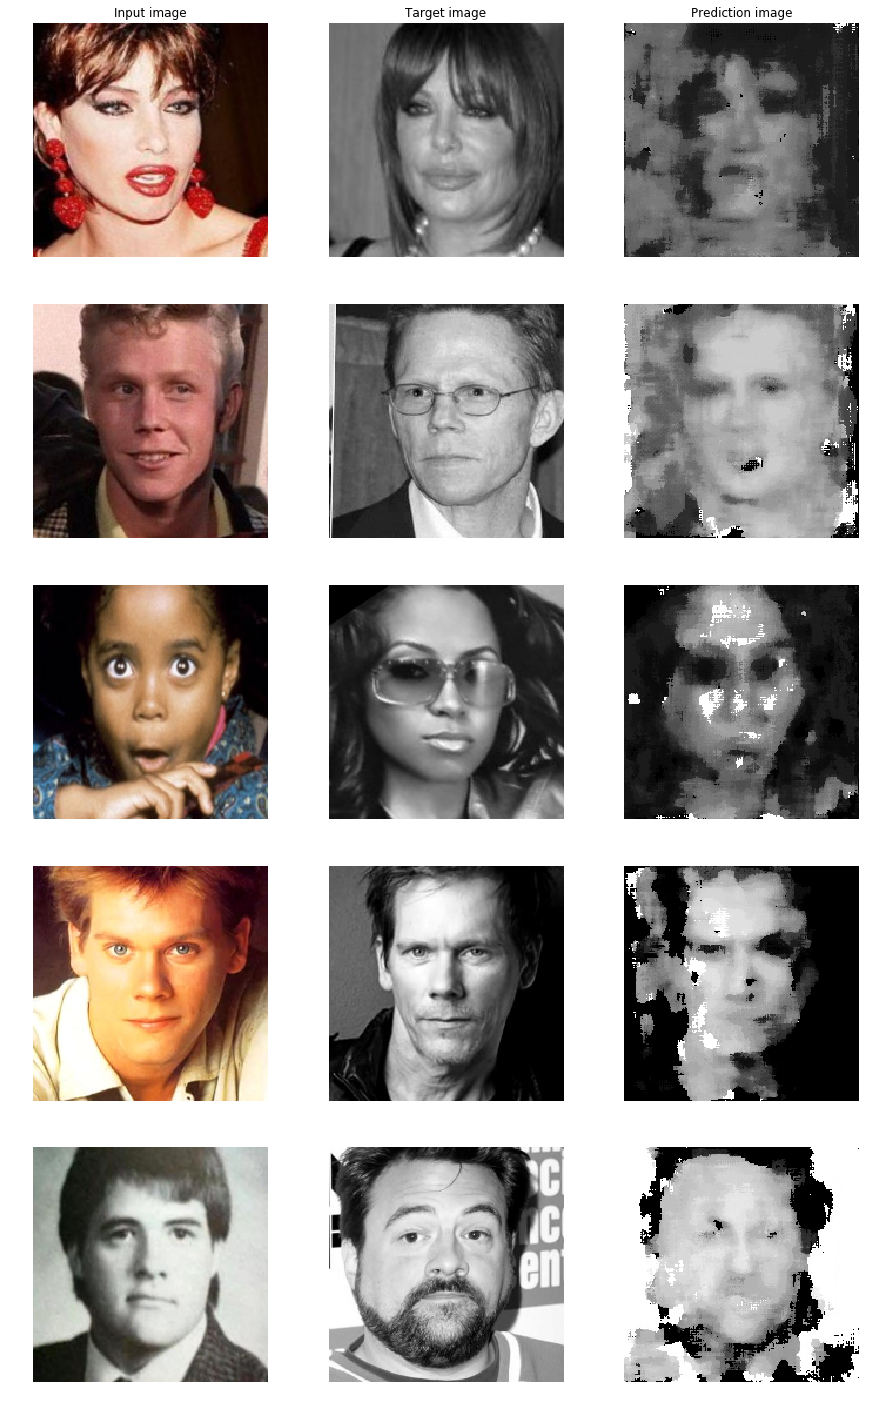

START TRAIN.
[Iteration 1/14890] TRAIN loss: 4.924
[Iteration 2/14890] TRAIN loss: 4.655
[Iteration 3/14890] TRAIN loss: 4.800
[Iteration 4/14890] TRAIN loss: 4.933
[Iteration 5/14890] TRAIN loss: 4.911
[Iteration 6/14890] TRAIN loss: 4.367
[Iteration 7/14890] TRAIN loss: 4.129
[Iteration 8/14890] TRAIN loss: 4.323
[Iteration 9/14890] TRAIN loss: 4.637
[Iteration 10/14890] TRAIN loss: 4.434
[Iteration 11/14890] TRAIN loss: 4.635
[Iteration 12/14890] TRAIN loss: 4.860
[Iteration 13/14890] TRAIN loss: 4.521
[Iteration 14/14890] TRAIN loss: 4.579
[Iteration 15/14890] TRAIN loss: 4.303
[Iteration 16/14890] TRAIN loss: 4.426
[Iteration 17/14890] TRAIN loss: 4.016
[Iteration 18/14890] TRAIN loss: 4.342
[Iteration 19/14890] TRAIN loss: 4.782
[Iteration 20/14890] TRAIN loss: 4.483
[Iteration 21/14890] TRAIN loss: 4.553
[Iteration 22/14890] TRAIN loss: 4.509
[Iteration 23/14890] TRAIN loss: 4.601
[Iteration 24/14890] TRAIN loss: 4.704
[Iteration 25/14890] TRAIN loss: 4.777
[Iteration 26/14890] 

Process Process-21:
Traceback (most recent call last):
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carlodedonno/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/carlodedonno/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle,

[Iteration 52/14890] TRAIN loss: 4.633


KeyboardInterrupt: 

In [3]:
from classifiers.convage_nn_2 import ConvAgeNN
from solver import Solver
import torch.nn.functional as F
import torchvision.models as models

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=1,
                                           shuffle=True,
                                           num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=1,
                                         shuffle=False,
                                         num_workers=1)
model = torch.load('models/convage_nn_2.model')
print(len(list(model.parameters())))

for param in list(model.parameters())[:2]:
    param.requires_grad = False    

solver = Solver(optim_args={"lr": 1e-3,
                            "eps": 1e-8
                            },
                loss_func = torch.nn.CrossEntropyLoss(ignore_index = -1))
for i in range(10):    
    solver.train(model, train_loader, val_loader, log_nth=1, num_epochs=10)
    model.save('models/convage_nn_2.model')
    num_example_imgs = 5
    plt.figure(figsize=(15, 5 * num_example_imgs))
    for i, (img, target) in enumerate(train_data[1000:1000+num_example_imgs]):
        inputs = img.unsqueeze(0)
        inputs = Variable(inputs)
        if model.is_cuda:
            inputs = inputs.cuda()

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        pred = preds[0].data.cpu()

        img, target, pred = img.numpy(), target.numpy(), pred.numpy()

        # img
        plt.subplot(num_example_imgs, 3, i * 3 + 1)
        plt.axis('off')
        plt.imshow(img.transpose(1,2,0))
        if i == 0:
            plt.title("Input image")

        # target
        plt.subplot(num_example_imgs, 3, i * 3 + 2)
        plt.axis('off')
        target /= 255
        plt.imshow(target.reshape(200,200), cmap='gray')
        if i == 0:
            plt.title("Target image")

        # pred
        plt.subplot(num_example_imgs, 3, i * 3 + 3)
        plt.axis('off')
        plt.imshow(pred.reshape(200,200), cmap='gray')
        if i == 0:
            plt.title("Prediction image")
    plt.show()

In [4]:
model = torch.load('models/convage_nn_2.model')

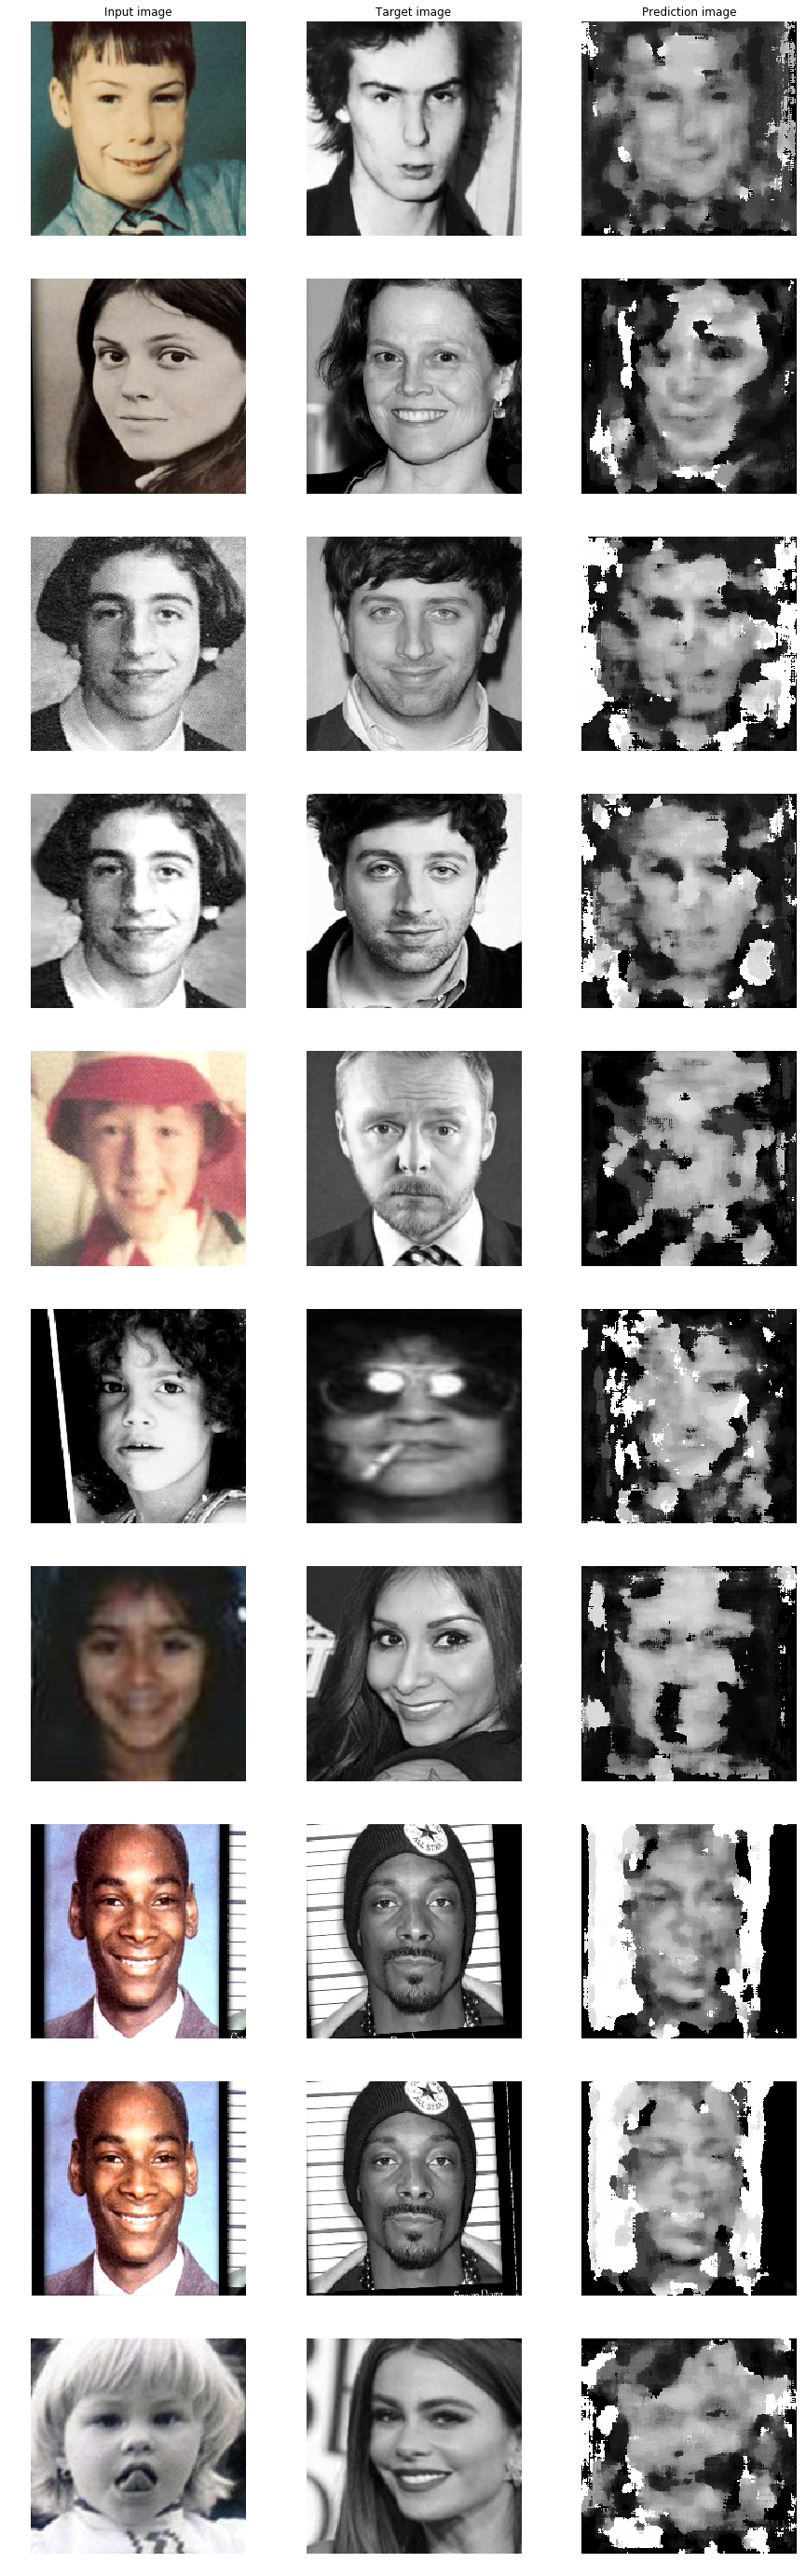

In [6]:
num_example_imgs = 10
plt.figure(figsize=(15, 5 * num_example_imgs))
for i, (img, target) in enumerate(val_data[70:70+num_example_imgs]):
    inputs = img.unsqueeze(0)
    inputs = Variable(inputs)
    if model.is_cuda:
        inputs = inputs.cuda()
    
    outputs = model.forward(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    img, target, pred = img.numpy(), target.numpy(), pred.numpy()
    
    # img
    plt.subplot(num_example_imgs, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(num_example_imgs, 3, i * 3 + 2)
    plt.axis('off')
    target /= 255
    plt.imshow(target.reshape(200,200), cmap='gray')
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(num_example_imgs, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(pred.reshape(200,200), cmap='gray')
    if i == 0:
        plt.title("Prediction image")
plt.show()

In [7]:
model.save("models/convage_nn_2.model")

Saving model... models/convage_nn_2.model


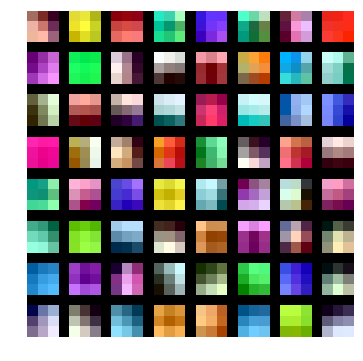

In [11]:
from vis_utils import visualize_grid

# first (next) parameter should be convolutional
conv_params = next(model.parameters()).data.cpu().numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()